In [ ]:
# !pip install .

# MOSEK setup for Colab (required for fast portfolio optimization)
# 1. Install MOSEK:
# !pip install mosek
# 2. Upload your mosek.lic file to Colab, then copy it:
# !mkdir -p ~/mosek && cp mosek.lic ~/mosek/mosek.lic

In [ ]:
# !nvidia-smi

In [ ]:
# %cd /content/Latent_risk_factor
# %run notebooks/dashboard.ipynb

# VAE Latent Risk Factor - Pipeline Dashboard

Central configuration and execution notebook for the full walk-forward validation pipeline.

**Workflow:**
1. Configure all parameters (Sections 1-2)
2. Load data (Section 3)
3. Run pipeline (Section 4)
4. Inspect results (Sections 5-7)

---
## 1. Setup

In [2]:
import os
import sys
import logging
from dataclasses import replace, asdict
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Project root: go up from notebooks/ to project root
_NB_DIR = Path(os.path.abspath("")).resolve()
PROJECT_ROOT = (_NB_DIR / "..").resolve() if _NB_DIR.name == "notebooks" else _NB_DIR
os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT))

from src.config import (
    PipelineConfig,
    DataPipelineConfig,
    VAEArchitectureConfig,
    LossConfig,
    TrainingConfig,
    InferenceConfig,
    RiskModelConfig,
    PortfolioConfig,
    WalkForwardConfig,
)
from src.data_pipeline.data_loader import load_data_source
from src.data_pipeline.returns import compute_log_returns
from src.data_pipeline.features import compute_trailing_volatility
from src.integration.pipeline import FullPipeline
from src.integration.reporting import export_results, format_summary_table
from src.integration.visualization import (
    plot_fold_metrics,
    plot_e_star_distribution,
    plot_pairwise_heatmap,
    style_summary_table,
    style_fold_table,
)
from src.utils import get_optimal_device
from src.walk_forward.selection import aggregate_fold_metrics, summary_statistics

%matplotlib inline
plt.rcParams["figure.dpi"] = 120

# force=True required in Colab/Jupyter where root logger is pre-configured
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(name)s: %(message)s", force=True)
logger = logging.getLogger("dashboard")

print(f"PyTorch {torch.__version__} | Device: {get_optimal_device()}")
print(f"Working directory: {os.getcwd()}")

/Users/mathis/Latent_risk_factor/Latent_risk_factor/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-13 22:28:04,560 [INFO] src.utils: Device auto-detected: MPS (Apple Silicon)


PyTorch 2.10.0 | Device: mps
Working directory: /Users/mathis/Latent_risk_factor/Latent_risk_factor


---
## 2. Configuration

Two configuration profiles are available. **Run ONLY one section:**
- **Section 2a** — Synthetic data: minimal parameters for quick end-to-end testing
- **Section 2b** — Real data: full production configuration

Always run the **Global** cell (below) first, then choose ONE section.

In [17]:
# ============================================================
# GLOBAL
# ============================================================
SEED = 42
DEVICE = str(get_optimal_device())

# Data source: "synthetic", "tiingo", or "csv"
DATA_SOURCE = "tiingo"
QUICK_MODE = False          # Set True for minimal config even with real data
RUN_FULL_PIPELINE = False   # Set False to skip training and inference (useful for quick visualization)

# Pretrained model: set to a checkpoint path to skip VAE training and re-run only portfolio optimization
# Set to None to train from scratch
CHECKPOINT_PATH = None  # e.g. "checkpoints/checkpoint_direct_N200_Y10_T504_K200_F2.pt"

# Tiingo API keys (used when DATA_SOURCE = "tiingo")
TIINGO_API_KEYS = [
    "9ba6e57788deaac3b3c38ed47047cabbbd6077e2",
    "9aad315d49275c400687f41dd26b22328d8b1a26",
]
DATA_DIR = "data/"          # Directory for Tiingo downloaded data

2026-02-13 22:28:06,134 [INFO] src.utils: Device auto-detected: MPS (Apple Silicon)


In [18]:
N_STOCKS = 1000                  #[⭐️] Top N stocks by median market cap (50=fast, 200=realistic, 0=all)
N_YEARS = 35                     #[⭐️] Years of history to keep
MIN_N_YEARS = 10                 # First fold trains on at least MIN_N_YEARS (shorter = unreliable model)
T = 504                          #[⭐️] Window length (trading days, ~2 years)
N_FEATURES = 2                   #[⭐️] Features per timestep (return + realized vol)
K = 50                          #[⭐️] Max latent factors the VAE can discover (only "active units" AU<=K are used)
LOSS_MODE = "P"                  # Loss mode: "P"=full ELBO with learned sigma^2, "F"=simplified with beta warmup, "A"=hybrid
CRISIS_OVERWEIGHTING = 3.0       #[⭐️] Crisis overweighting: crisis windows count 3x more in reconstruction loss
MAX_CO_MOVEMENT_WEIGHT = 0.5     # Max co-movement weight: how strongly latent distances must match Spearman correlations

MAX_EPOCHS = 250                 #[⭐️] Max training epochs (early stopping may halt training sooner)
BATCH_SIZE = 512                 # Training batch size (windows)
LEARNING_RATE = 5e-3             # Adam learning rate
EARLY_STOPPING_PATIENCE = 20     # Early stopping patience (epochs)
LR_PATIENCE = 10                 # Early stopping: stop after 10 epochs without validation improvement on val/ELBO
LR_FACTOR = 0.75                  # Reduce LR if validation stagnates for 5 epochs (triggers before early stop)
DROPOUT = 0.2
TRAINING_STRIDE = 21             # Training window stride (21 = one window per month per stock, faster training)
COMPILE_MODEL = True             # torch.compile on CUDA/MPS (faster forward/backward, ~30s warmup)

AU_THRESHOLD = 0.01              # KL > 0.01 nats = dimension is "active" (below = unused, posterior ≈ prior)
AGGREGATION_METHOD = "mean"      # Method to aggregate overlapping window predictions ("mean", "median", etc.)

HP_GRID = None                   # HP GRID for Phase A (set to None for default 18-config grid : 3 loss modes × 2 learning rates × 3 alphas = 18 configs)
                                 # Phase A tries all configs on nested validation to find the best HP set per fold
                
# Uncomment to define a custom grid (faster, but less thorough HP search):
# HP_GRID = [
#     {"mode": "P", "learning_rate": 5e-4, "alpha": 1.0},   # mode: loss formulation, alpha: risk-entropy tradeoff
#     {"mode": "F", "learning_rate": 1e-3, "alpha": 0.5},
#     {"mode": "A", "learning_rate": 1e-3, "alpha": 2.0},
# ]

In [19]:
# ============================================================
# Variance (w'Σw) = total portfolio risk. Minimizing it concentrates
# weight on low-vol stocks — but can put 85% of risk on 2-3 latent
# factors without noticing (fragile to factor shocks).
#
# Entropy H(w) = Shannon entropy on each factor's risk contribution.
# Maximizing it spreads risk evenly across all active factors — no
# single factor dominates (resilient to individual factor crashes).
#
# lambda_risk and alpha control the tradeoff: more lambda_risk favors
# low total variance; more alpha favors even factor risk distribution.
#
# lambda_risk guide:
#   0.1  → entropy dominates (pure factor risk parity, higher variance OK)
#   0.5  → entropy favored, soft variance constraint
#   1.0  → balanced (default, let alpha_grid find the right ratio)
#   2.0  → variance favored (more conservative, fewer dominant factors OK)
#   5.0+ → near min-variance (entropy has little influence)
#
# Penalty tuning guide (defaults calibrated for US mid/large cap):
#   Illiquid universe (small caps) → raise kappa_1 & kappa_2
#   Infrequent rebalancing         → lower kappa_1 & kappa_2
#   Allow more concentrated bets   → lower phi and/or raise w_bar
#   Force tighter diversification  → raise phi and/or lower w_bar
#   Smoother trades                → lower delta_bar (e.g. 0.005)
#
# Valid ranges from DVT spec:
#   phi: [5, 100]  kappa_1: [0.01, 1.0]  kappa_2: [1, 50]  delta_bar: [0.005, 0.03]
# ============================================================

LAMBDA_RISK = 1.0                #[⭐️] Risk aversion (higher = more conservative, lower variance portfolio)

W_MAX = 0.05                      # Max 5% per stock (hard cap, prevents single-stock concentration)
W_MIN = 0.001                    # Min active weight: below this, stock is eliminated (0 or >= 0.1%)
W_BAR = 0.03                     # Concentration penalty kicks in above 3% weight per stock

PHI = 25.0                       # Concentration penalty strength above w_bar (higher = stronger diversification pressure)
KAPPA_1 = 0.1                    # Linear turnover penalty (penalizes trading costs at rebalance)
KAPPA_2 = 7.5                    # Quadratic turnover penalty (penalizes large trades more than small ones)
DELTA_BAR = 0.01                 # Turnover below 1% is not penalized (de minimis threshold)
MAX_TURNOVER = 0.30              #[⭐️] Max 30% turnover per rebalance (prevents excessive trading costs)

ALPHA_GRID = [0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]

SCA_N_STARTS = 3                # Multi-start optimizations (more = better optimum, proportionally slower)

### Parameters details


#### Data Pipeline Parameters

| Parameter | What it controls |
|---|---|
| `n_stocks` | Universe size — how many stocks to keep (ranked by market cap). More = better diversification, slower training. |
| `window_length` | Length of each input window in trading days. 504 ≈ 2 years of daily data. Each stock produces many overlapping windows. |
| `n_features` | Features per timestep. 2 = log-return + realized volatility. |
| `vol_window` | Lookback (trading days) for trailing volatility computation. 252 ≈ 1 year. |
| `vix_lookback_percentile` | VIX percentile above which a day is labeled "crisis". Higher = fewer crisis days = less overweighting. |
| `min_valid_fraction` | Minimum fraction of non-missing data to keep a stock. 0.80 = stocks missing >20% of their history are dropped. |

#### VAE Architecture Parameters

| Parameter | What it controls |
|---|---|
| `K` | Maximum latent capacity — how many risk factors the VAE *can* learn. Only "active units" (AU ≤ K) are actually used. Typical: 100-200. |
| `sigma_sq_init` | Starting value of learned observation noise σ². 1.0 = assume noise equals signal at first. The model learns the true value during training (Mode P/A). |
| `sigma_sq_min` / `sigma_sq_max` | Clamp bounds for σ². Prevents extreme values: too small = overfitting (model claims perfect reconstruction), too large = underfitting (model gives up). |
| `window_length` / `n_features` | Must match DataPipelineConfig — determines input tensor shape (T×F). |
| `r_max` | Maximum ratio of model parameters to data points. Safety guard — if the CNN has more parameters than the data can support, training is rejected. Relaxed automatically for small universes. |

#### Loss Function Parameters

| Parameter | What it controls |
|---|---|
| `mode` | Loss formulation. **P** = full probabilistic ELBO with learned σ² (recommended). **F** = simplified with β warmup, σ² frozen at 1.0 (use if Mode P diverges). **A** = hybrid with tunable KL weight β. |
| `gamma` | Crisis overweighting factor. 3.0 = windows falling in crisis periods (high VIX) count 3× more in reconstruction loss. Forces the model to learn crisis dynamics well. |
| `lambda_co_max` | Maximum co-movement loss weight. Controls how strongly latent distances must match stock Spearman correlations. Active during Phases 1-2, decays to 0 in Phase 3. |
| `beta_fixed` | Fixed KL weight for Mode A (must be 1.0 for Mode P). Values <1 reduce regularization pressure, giving more freedom to reconstruction. |
| `warmup_fraction` | Fraction of training where β ramps 0→1 (Mode F only). Prevents posterior collapse by letting the model learn to reconstruct before enforcing KL regularization. |
| `max_pairs` | Max stock pairs sampled per batch for co-movement loss. Limits compute cost — full pairwise is O(B²). |
| `delta_sync` | Maximum date gap (calendar days) for windows to be "synchronized" in the same time block. 21 ≈ 1 month. Ensures co-movement comparisons are temporally valid. |

#### Training Parameters

| Parameter | What it controls |
|---|---|
| `max_epochs` | Hard limit on training duration. Training may stop earlier via early stopping. |
| `batch_size` | Windows per gradient update. Larger = smoother gradients but more memory. 512 is a good default on A100. |
| `learning_rate` | Initial optimizer step size (η₀). Too high → loss diverges. Too low → converges very slowly. Typical: 1e-4 to 1e-3. |
| `weight_decay` | L2 regularization on model weights. Penalizes large weights to reduce overfitting. 1e-5 is mild. |
| `adam_betas` / `adam_eps` | Adam optimizer internals (momentum and numerical stability). Rarely need tuning. |
| `patience` | **Early stopping** — if validation ELBO doesn't improve for this many consecutive epochs, stop training and restore the best checkpoint. |
| `lr_patience` | **LR reduction** — if validation stagnates for this many epochs, multiply LR by `lr_factor`. Triggers before early stopping. |
| `lr_factor` | LR reduction multiplier. 0.5 = halve the learning rate each time it triggers. |
| `n_strata` | Number of volatility-based groups for stratified batching (Phases 1-2). Ensures each batch contains stocks from all risk profiles, not just one cluster. |
| `curriculum_phase1_frac` | Fraction of epochs for Phase 1 (co-movement at full strength + synchronized batching). |
| `curriculum_phase2_frac` | Fraction of epochs for Phase 2 (co-movement linearly decaying). Phase 3 = remainder (free refinement, random batching). |
| `training_stride` | Window stride for training data. 21 = one window per month per stock (21× fewer windows, much faster). Inference always uses stride=1. |
| `compile_model` | Enable `torch.compile` on CUDA/MPS for faster forward/backward passes. ~30s warmup cost, then ~20-40% speedup. |

#### Inference Parameters

| Parameter | What it controls |
|---|---|
| `batch_size` | Batch size for inference pass. Can be larger than training (no gradients stored = less memory). |
| `au_threshold` | KL threshold in nats to consider a latent dimension "active". 0.01 is standard — dimensions with KL < 0.01 are effectively unused (posterior ≈ prior). |
| `r_min` | Minimum observations-per-parameter ratio. Caps AU_max = ⌊√(2·N_obs/r_min)⌋ to prevent more active factors than the data can reliably estimate. |
| `aggregation_method` | How to combine predictions from overlapping windows for the same stock. "mean" averages all windows. |

#### Risk Model Parameters

| Parameter | What it controls |
|---|---|
| `winsorize_lo` / `winsorize_hi` | Percentile bounds for clipping extreme volatility ratios during rescaling. [5, 95] = trim the 5% most extreme values on each side. |
| `d_eps_floor` | Minimum idiosyncratic (stock-specific) variance. Prevents division by zero when a stock has near-zero residual risk. |
| `conditioning_threshold` | If the covariance matrix condition number exceeds this, the factor regression switches to ridge regression for numerical stability. |
| `ridge_scale` | Ridge regularization strength when the fallback activates. Small value (1e-6) = minimal regularization, just enough to stabilize. |


#### Portfolio Optimization Parameters

| Parameter | What it controls |
|---|---|
| `lambda_risk` | Risk aversion. Higher = portfolio avoids variance more aggressively, at the cost of lower expected return. |
| `w_max` | Hard cap per stock. 0.05 = no stock can exceed 5% of the portfolio. |
| `w_min` | Minimum active weight. Stocks allocated below this are eliminated entirely (semi-continuous: either 0 or ≥ w_min). |
| `w_bar` | Concentration penalty threshold. Stocks above this weight get penalized to encourage diversification. |
| `phi` | Concentration penalty strength. Higher = more aggressively pushes weights below w_bar. |
| `kappa_1` / `kappa_2` | Linear and quadratic turnover penalties. Penalize trading costs when rebalancing. Higher = more stable portfolio across rebalances. |
| `delta_bar` | Turnover penalty threshold — small weight changes below this are not penalized. |
| `tau_max` | Maximum one-way turnover per rebalance. 0.30 = at most 30% of the portfolio can change in a single rebalance. |
| `n_starts` | Multi-start initializations for the SCA optimizer. More starts = higher chance of finding the global optimum, but proportionally slower. |
| `sca_max_iter` / `sca_tol` | SCA (Sequential Convex Approximation) iteration limit and convergence tolerance. |
| `armijo_*` | Line search parameters (sufficient decrease, backtracking factor, max steps). Controls step size selection within SCA. |
| `max_cardinality_elim` | Maximum rounds of sequential stock elimination to enforce the minimum weight constraint. |
| `entropy_eps` | Tiny constant (1e-30) added inside log() to avoid log(0). Pure numerical safety. |
| `alpha_grid` | Grid of α values for the variance-entropy frontier. The optimizer tries each α and picks the best tradeoff between risk and factor diversification. |


#### Walk-Forward Validation Parameters

| Parameter | What it controls |
|---|---|
| `total_years` | Total history length used for the walk-forward. More years = more folds = more robust evaluation, but requires more data. |
| `min_training_years` | Minimum training window. The first fold starts with this many years of training data. Too small = unreliable model, too large = few folds. |
| `oos_months` | Out-of-sample test period per fold. After training, the portfolio is tested on this many months, then the window slides forward. |
| `embargo_days` | Gap (trading days) between training end and OOS start. Prevents information leakage from overlapping windows near the boundary. 21 ≈ 1 month. |
| `holdout_years` | Final holdout period excluded from all training/testing. Reserved for ultimate out-of-sample validation. |
| `val_years` | Nested validation window within training for Phase A hyperparameter selection. Used to score HP configs without touching OOS data. |
| `score_lambda_pen` | Weight of maximum drawdown penalty in the composite HP scoring function. Higher = favor configs with lower drawdowns. |
| `score_lambda_est` | Weight of estimation quality penalty (variance ratio) in scoring. Higher = favor configs with more accurate risk predictions. |
| `score_mdd_threshold` | Maximum drawdown threshold. Drawdowns beyond this are heavily penalized in the composite score. |

### 2a. Quick Mode

Run **only this cell** to configure the pipeline for a minimal end-to-end test. Skip Section 2b entirely.

In [20]:
# ============================================================
# QUICK MODE — Minimal config for end-to-end testing
# Run ONLY this cell, then jump to Section 3
# ============================================================

if QUICK_MODE == True or DATA_SOURCE == "synthetic":
    DATA_PATH = ""
    N_STOCKS = 50   # How many stocks in the universe (ranked by market cap)
    N_YEARS = 20    # Years of history to use

    config = PipelineConfig(
        data=DataPipelineConfig(
            n_stocks=N_STOCKS,       # Universe size (top N by market cap)
            window_length=504,       # Input window = 504 trading days (~2 years)
            n_features=2,            # 2 features per timestep: log-return + realized vol
            training_stride=TRAINING_STRIDE,  # Window stride for training (21 = monthly, 1 = daily)
        ),
        vae=VAEArchitectureConfig(
            K=100,                   # Max latent factors the VAE can discover (only AU will be active)
            window_length=504,       # Must match data window_length
            n_features=2,            # Must match data n_features
            r_max=5.0,               # Max param/data ratio (relaxed for small universes, auto-adjusted)
        ),
        loss=LossConfig(
            mode="P",                # "P" = full probabilistic ELBO with learned observation noise sigma^2
        ),
        training=TrainingConfig(
            max_epochs=50,           # Hard limit on training (early stopping may trigger sooner)
            batch_size=512,          # Windows per gradient update (512 = good balance speed/stability)
            learning_rate=1e-4,      # Initial optimizer step size (typical: 1e-4 to 1e-3)
            patience=30,             # Stop if validation doesn't improve for 30 epochs
            compile_model=COMPILE_MODEL,  # torch.compile on CUDA/MPS
        ),
        inference=InferenceConfig(),   # Defaults: batch_size=512, au_threshold=0.01, r_min=2
        risk_model=RiskModelConfig(),  # Defaults: winsorize=[5,95], cond_threshold=1e6, ridge=1e-6
        portfolio=PortfolioConfig(
            n_starts=2,              # Multi-start optimizations (2 = fast, 5+ = production)
        ),
        walk_forward=WalkForwardConfig(
            total_years=N_YEARS,             # Total history for walk-forward folds
            min_training_years=max(3, N_YEARS // 3),  # Min training window (>=3y for reliability)
            holdout_years=max(1, N_YEARS // 5),       # Final holdout excluded from all folds (>=1y)
        ),
        seed=SEED,
    )

    # Single HP config (skip Phase A grid search for speed)
    HP_GRID = [{"mode": "P", "learning_rate": 1e-4, "alpha": 1.0}]

    print(f"[Quick mode] {N_STOCKS} stocks, {N_YEARS} years, K={config.vae.K}")
    print(f"  max_epochs={config.training.max_epochs}, patience={config.training.patience}, HP_GRID=1 config, n_starts=2")
    print(f"  r_max={config.vae.r_max:.0e}, training_stride={config.data.training_stride}, compile={config.training.compile_model}")
    print(f"  Walk-forward: {config.walk_forward.total_years}y total, "
        f"{config.walk_forward.min_training_years}y min training, "
        f"{config.walk_forward.holdout_years}y holdout")
    print(f"  Device: {DEVICE}")

### 2b. Real Data (Production)

Run **all cells below** (through "ASSEMBLE FULL CONFIG") for full production configuration. Skip Section 2a.

In [21]:
# ============================================================
# DATA SOURCE — Real data
# ============================================================
# For CSV source:
DATA_PATH = "data/stock_data.csv"  # <-- Set path to your stock data CSV

# For Tiingo source: run download first:
#   python scripts/download_tiingo.py --phase all --keys-file keys.txt
# Then set DATA_SOURCE = "tiingo" in Global cell above.

#### Data Pipeline Parameters

| Parameter | What it controls |
|---|---|
| `n_stocks` | Universe size — how many stocks to keep (ranked by market cap). More = better diversification, slower training. |
| `window_length` | Length of each input window in trading days. 504 ≈ 2 years of daily data. Each stock produces many overlapping windows. |
| `n_features` | Features per timestep. 2 = log-return + realized volatility. |
| `vol_window` | Lookback (trading days) for trailing volatility computation. 252 ≈ 1 year. |
| `vix_lookback_percentile` | VIX percentile above which a day is labeled "crisis". Higher = fewer crisis days = less overweighting. |
| `min_valid_fraction` | Minimum fraction of non-missing data to keep a stock. 0.80 = stocks missing >20% of their history are dropped. |

In [22]:
# ============================================================
# DATA PIPELINE (MOD-001)
# ============================================================
data_cfg = DataPipelineConfig(
    n_stocks=N_STOCKS,           # universe cap (same as N_STOCKS above)
    window_length=T,             # T: sliding window length (trading days)
    n_features=N_FEATURES,       # F: features per timestep (return + realized vol)
    vol_window=252,              # trailing vol lookback (days)
    vix_lookback_percentile=80.0,# VIX percentile for crisis threshold
    min_valid_fraction=0.80,     # Drop stocks missing >20% of their price history
    training_stride=TRAINING_STRIDE,  # Window stride for training (21 = monthly, 1 = daily; inference always uses stride=1)
)

In [23]:
# ============================================================
# VAE ARCHITECTURE (MOD-002)
# ============================================================
vae_cfg = VAEArchitectureConfig(
    K=K,                                   # Max latent factors the VAE can discover (only "active units" AU<=K are used)
    sigma_sq_init=1.0,                     # Initial observation noise (1.0 = assume noise = signal, model learns true value)
    sigma_sq_min=0.5,                     # Lower clamp for sigma^2 (prevents overfitting: model can't claim 0 noise)
    sigma_sq_max=10.0,                     # Upper clamp for sigma^2 (prevents divergence: model can't give up entirely)
    window_length=data_cfg.window_length,  # Must match data_cfg.window_length
    n_features=data_cfg.n_features,        # Must match data_cfg.n_features
    r_max=5.0,                             # Max model params / data points ratio (safety guard against overfitting)
    dropout=DROPOUT,                           # Dropout rate for VAE residual blocks (0.1=standard, 0.2=reinforced for small universes)
)

print(f"Encoder depth L={vae_cfg.encoder_depth}, "
      f"Final width C_L={vae_cfg.final_layer_width}, "
      f"D={vae_cfg.D}")

Encoder depth L=5, Final width C_L=384, D=1008


In [24]:
# ============================================================
# LOSS FUNCTION (MOD-004)
# ============================================================
loss_cfg = LossConfig(
    mode=LOSS_MODE,                        # Loss mode: "P"=full ELBO with learned sigma^2, "F"=simplified with beta warmup, "A"=hybrid
    gamma=CRISIS_OVERWEIGHTING,            # Crisis overweighting: crisis windows count 3x more in reconstruction loss
    lambda_co_max=MAX_CO_MOVEMENT_WEIGHT,  # Max co-movement weight: how strongly latent distances must match Spearman correlations
    beta_fixed=1.0,                        # Fixed KL weight for Mode A (must be 1.0 for Mode P)
    warmup_fraction=0.20,                  # Mode F only: fraction of epochs to ramp beta 0->1 (prevents posterior collapse)
    max_pairs=2048,                        # Max stock pairs per batch for co-movement loss (limits O(B^2) compute)
    delta_sync=21,                         # Max date gap (days) for windows to be "synchronized" (21 ≈ 1 month)
)

In [25]:
# ============================================================
# TRAINING (MOD-005)
# ============================================================
training_cfg = TrainingConfig(
    max_epochs=MAX_EPOCHS,            # Hard limit on training duration (early stopping usually triggers sooner)
    batch_size=BATCH_SIZE,            # Windows per gradient step (larger = smoother but more memory)
    learning_rate=LEARNING_RATE,      # Initial optimizer step size (too high = diverges, too low = slow)
    weight_decay=1e-3,                # L2 penalty on weights to reduce overfitting (1e-5 = mild)
    adam_betas=(0.9, 0.999),          # Adam momentum parameters (rarely need tuning)
    adam_eps=1e-8,                    # Adam numerical stability constant (rarely need tuning)
    patience=EARLY_STOPPING_PATIENCE, # Early stopping: stop after 10 epochs without validation improvement
    lr_patience=LR_PATIENCE,          # Reduce LR if validation stagnates for 5 epochs (triggers before early stop)
    lr_factor=LR_FACTOR,              # LR multiplier when reducing (0.5 = halve each time)
    n_strata=15,                      # Volatility groups for stratified batching (ensures risk diversity per batch)
    curriculum_phase1_frac=0.30,      # Phase 1: 30% of epochs with full co-movement + synchronized batching
    curriculum_phase2_frac=0.30,      # Phase 2: 30% of epochs with co-movement linearly decaying to 0
                                      # Phase 3: remaining 40% with no co-movement, random batching
    compile_model=COMPILE_MODEL,      # torch.compile on CUDA/MPS (faster forward/backward, ~30s warmup)
)

In [26]:
# ============================================================
# INFERENCE (MOD-006)
# After training, the encoder runs on all windows to extract each stock's
# latent profile. These parameters control that extraction pass and
# decide how many latent dimensions are kept as "active" risk factors.
# ============================================================
inference_cfg = InferenceConfig(
    batch_size=512,                          # Larger than training (no gradients = less memory needed)
    au_threshold=AU_THRESHOLD,               # KL > 0.01 nats = dimension is "active" (below = unused, posterior ≈ prior)
    r_min=2,                                 # Min data/param ratio — caps AU_max to prevent more factors than data supports
    aggregation_method=AGGREGATION_METHOD,   # Average overlapping window predictions for each stock's final profile
)

In [27]:
# ============================================================
# RISK MODEL (MOD-007)
# Transforms latent exposures (B matrix) into a full covariance
# matrix Sigma_assets via cross-sectional regression and
# Ledoit-Wolf shrinkage. These parameters handle numerical
# edge cases (extreme vol ratios, ill-conditioned matrices).
# ============================================================
risk_model_cfg = RiskModelConfig(
    winsorize_lo=5.0,            # Clip extreme vol ratios below 5th percentile (removes outliers)
    winsorize_hi=95.0,           # Clip extreme vol ratios above 95th percentile
    d_eps_floor=1e-6,            # Min idiosyncratic variance per stock (prevents division by zero)
    conditioning_threshold=1e6,  # Switch to ridge regression if covariance condition number exceeds this
    ridge_scale=1e-6,            # Ridge regularization strength (tiny, just enough to stabilize)
)

In [28]:
# ============================================================
# PORTFOLIO OPTIMIZATION (MOD-008)
# Constraints identical for VAE and all 6 benchmarks (INV-012)
#
# Variance (w'Σw) = total portfolio risk. Minimizing it concentrates
# weight on low-vol stocks — but can put 85% of risk on 2-3 latent
# factors without noticing (fragile to factor shocks).
#
# Entropy H(w) = Shannon entropy on each factor's risk contribution.
# Maximizing it spreads risk evenly across all active factors — no
# single factor dominates (resilient to individual factor crashes).
#
# lambda_risk and alpha control the tradeoff: more lambda_risk favors
# low total variance; more alpha favors even factor risk distribution.
#
# lambda_risk guide:
#   0.1  → entropy dominates (pure factor risk parity, higher variance OK)
#   0.5  → entropy favored, soft variance constraint
#   1.0  → balanced (default, let alpha_grid find the right ratio)
#   2.0  → variance favored (more conservative, fewer dominant factors OK)
#   5.0+ → near min-variance (entropy has little influence)
#
# Penalty tuning guide (defaults calibrated for US mid/large cap):
#   Illiquid universe (small caps) → raise kappa_1 & kappa_2
#   Infrequent rebalancing         → lower kappa_1 & kappa_2
#   Allow more concentrated bets   → lower phi and/or raise w_bar
#   Force tighter diversification  → raise phi and/or lower w_bar
#   Smoother trades                → lower delta_bar (e.g. 0.005)
#
# Valid ranges from DVT spec:
#   phi: [5, 100]  kappa_1: [0.01, 1.0]  kappa_2: [1, 50]  delta_bar: [0.005, 0.03]
# ============================================================
portfolio_cfg = PortfolioConfig(
    lambda_risk=LAMBDA_RISK,     # Risk aversion (higher = more conservative, lower variance portfolio)
    w_max=W_MAX,                 # Max 5% per stock (hard cap, prevents single-stock concentration)
    w_min=W_MIN,                 # Min active weight: below this, stock is eliminated (0 or >= 0.1%)
    w_bar=W_BAR,                 # Concentration penalty kicks in above 3% weight per stock
    phi=PHI,                     # Concentration penalty strength above w_bar (higher = stronger diversification pressure)
    kappa_1=KAPPA_1,             # Linear turnover penalty (penalizes trading costs at rebalance)
    kappa_2=KAPPA_2,             # Quadratic turnover penalty (penalizes large trades more than small ones)
    delta_bar=DELTA_BAR,         # Turnover below 1% is not penalized (de minimis threshold)
    tau_max=MAX_TURNOVER,        # Max 30% portfolio change per rebalance (hard cap on turnover)
    n_starts=SCA_N_STARTS,       # Multi-start optimizations (more = better optimum, proportionally slower)
    sca_max_iter=100,            # Max iterations for the SCA convex optimizer
    sca_tol=1e-8,                # SCA convergence tolerance (stop when improvement < this)
    armijo_c=1e-4,               # Line search: sufficient decrease constant
    armijo_rho=0.5,              # Line search: backtracking factor (halve step on each retry)
    armijo_max_iter=20,          # Line search: max backtracking attempts per SCA step
    max_cardinality_elim=100,    # Max rounds of stock elimination to enforce w_min constraint
    entropy_eps=1e-30,           # Tiny constant in log() for numerical safety (avoids log(0))
    alpha_grid=ALPHA_GRID,  # Risk-entropy tradeoff grid (optimizer picks best alpha)
)

In [29]:
# ============================================================
# WALK-FORWARD VALIDATION (MOD-009)
# ============================================================
walk_forward_cfg = WalkForwardConfig(
    total_years=N_YEARS,            # Total history used (more years = more folds = more robust evaluation)
    min_training_years=MIN_N_YEARS, # First fold trains on at least MIN_N_YEARS (shorter = unreliable model)
    oos_months=6,                   # Test each fold on 6 months out-of-sample, then slide forward
    embargo_days=21,                # 21-day gap between training and test (prevents data leakage from windows)
    holdout_years=3,                # Last 3 years excluded from all folds (final out-of-sample validation)
    val_years=2,                    # 2-year nested validation within training for HP selection (Phase A)
    score_lambda_pen=5.0,           # HP scoring: penalty weight for max drawdown (higher = favor low-drawdown configs)
    score_lambda_est=2.0,           # HP scoring: penalty weight for poor risk estimation accuracy
    score_mdd_threshold=0.20,       # HP scoring: drawdowns above 20% get heavily penalized
)

In [30]:
# ============================================================
# ASSEMBLE FULL CONFIG
# ============================================================
if DATA_SOURCE != "synthetic" and QUICK_MODE == False:
      config = PipelineConfig(
            data=data_cfg,
            vae=vae_cfg,
            loss=loss_cfg,
            training=training_cfg,
            inference=inference_cfg,
            risk_model=risk_model_cfg,
            portfolio=portfolio_cfg,
            walk_forward=walk_forward_cfg,
            seed=SEED,
      )

      print("PipelineConfig assembled.")
      print(f"  Walk-forward: {config.walk_forward.total_years}y total, "
            f"{config.walk_forward.min_training_years}y min training, "
            f"{config.walk_forward.holdout_years}y holdout")
      print(f"  VAE: K={config.vae.K}, T={config.vae.window_length}, F={config.vae.n_features}")
      print(f"  Training: {config.training.max_epochs} max epochs, "
            f"bs={config.training.batch_size}, lr={config.training.learning_rate}")
      print(f"  Loss mode: {config.loss.mode}, gamma={config.loss.gamma}")
      print(f"  Capacity guard r_max: {config.vae.r_max}")
      print(f"  Device: {DEVICE}")

PipelineConfig assembled.
  Walk-forward: 35y total, 10y min training, 3y holdout
  VAE: K=50, T=504, F=2
  Training: 250 max epochs, bs=512, lr=0.005
  Loss mode: P, gamma=3.0
  Capacity guard r_max: 5.0
  Device: mps


---
## 3. Data Loading

### 3a. Tiingo Download (run once)

Run this cell **only once** to download Tiingo data. After the first run, the data is saved locally and reused automatically.
Set `MAX_TICKERS` to a small number (e.g. 5) for testing, or `None` for the full universe.

In [31]:
# ============================================================
# TIINGO DOWNLOAD — Run once, data is saved locally
# Skip this cell if data is already downloaded or DATA_SOURCE != "tiingo"
# ============================================================

if DATA_SOURCE == "tiingo":
    import importlib.util

    _spec = importlib.util.spec_from_file_location(
        "download_tiingo", str(PROJECT_ROOT / "scripts" / "download_tiingo.py")
    )
    _mod = importlib.util.module_from_spec(_spec)
    _spec.loader.exec_module(_mod)  # type: ignore[union-attr]

    MAX_TICKERS = None  # Set to None for full universe (~22k tickers)

    _mod.run_download(
        api_keys=TIINGO_API_KEYS,
        data_dir=DATA_DIR,
        max_tickers=MAX_TICKERS,
        sp500_first=True,  # Download SP500 tickers first (priority)
    )
else:
    print(f"DATA_SOURCE={DATA_SOURCE}, skipping Tiingo download.")

2026-02-13 22:28:08,078 [INFO] download_tiingo: Validating 2 API key(s)...
2026-02-13 22:28:08,450 [INFO] download_tiingo: Key #1 valid (masked: ...77e2)
2026-02-13 22:28:08,839 [INFO] download_tiingo: Key #2 valid (masked: ...1a26)
2026-02-13 22:28:08,841 [INFO] download_tiingo: 2/2 keys valid.
2026-02-13 22:28:08,841 [INFO] download_tiingo: === Phase 1: Ticker Discovery ===
2026-02-13 22:28:08,842 [INFO] download_tiingo: Downloading supported tickers list from Tiingo...
2026-02-13 22:28:09,183 [INFO] download_tiingo: Fetching S&P 500 constituent list from Wikipedia...
2026-02-13 22:28:09,557 [INFO] download_tiingo: Found 503 S&P 500 tickers from Wikipedia
2026-02-13 22:28:09,563 [INFO] download_tiingo: SP500 priority: 519 SP500 tickers first, then 21880 others
2026-02-13 22:28:09,585 [INFO] download_tiingo: Saved 22399 US equity tickers (6685 active, 15714 delisted) to data/tiingo_meta/supported_tickers.csv
2026-02-13 22:28:09,602 [INFO] download_tiingo: Assigned permnos to 22399 tic

In [32]:
np.random.seed(SEED)

stock_data, start_date = load_data_source(
    source=DATA_SOURCE,
    data_path=DATA_PATH if DATA_SOURCE == "csv" else "",
    data_dir=DATA_DIR,
    n_stocks=N_STOCKS,
    n_years=N_YEARS,
    seed=SEED,
)

print(f"Data source: {DATA_SOURCE}")
print(f"Stock data shape: {stock_data.shape}")
print(f"Date range: {stock_data['date'].min()} to {stock_data['date'].max()}")
print(f"Unique stocks: {stock_data['permno'].nunique()}")
stock_data.head()

Data source: tiingo
Stock data shape: (3870731, 8)
Date range: 1995-01-03 00:00:00 to 2026-02-12 00:00:00
Unique stocks: 739


,permno,date,adj_price,volume,exchange_code,share_code,market_cap,delisting_return
0,10002,2023-08-30,10.865612,200,3,10,48000.0,NaN
1,10002,2023-08-31,10.865612,1,3,10,24120.0,NaN
2,10002,2023-09-01,10.865612,0,3,10,16080.0,NaN
3,10002,2023-09-05,10.865612,0,3,10,12060.0,NaN
4,10002,2023-09-06,10.865612,0,3,10,9648.0,NaN


In [33]:
# Compute log-returns and trailing volatility
returns = compute_log_returns(stock_data)
trailing_vol = compute_trailing_volatility(returns, window=config.data.vol_window)

nb_effective_years = returns.shape[0]/252
nb_effective_stocks = returns.shape[1]

print(f"Returns: {returns.shape[0]} dates x {returns.shape[1]} stocks")
print(f"Trailing vol: {trailing_vol.shape} (first {config.data.vol_window-1} rows NaN)")
print(f"Returns date range: {returns.index[0]} to {returns.index[-1]}")

Returns: 7873 dates x 739 stocks
Trailing vol: (7873, 739) (first 251 rows NaN)
Returns date range: 1995-01-03 00:00:00 to 2026-02-12 00:00:00


---
## 4. Run Pipeline

Executes the full walk-forward validation: Phase A (HP selection) + Phase B (deployment) on each fold, then benchmarks, statistical tests, and report generation.

### Metric Value Interpretation

The input windows are **z-scored** (mean=0, std=1), so metric values are directly interpretable as fractions of signal variance.

#### `reconstruction` (Step/ and Loss/)
Raw per-element MSE **before** D/(2σ²) scaling. Since data is z-scored, L_recon ≈ fraction of unexplained variance.

| L_recon | RMSE | Interpretation |
|---|---|---|
| **1.0** | 1.0 | No better than predicting the mean. Not learning. |
| **0.5** | 0.71 | ~50% variance explained. Poor. |
| **0.1** | 0.32 | ~90% variance explained. Decent. |
| **0.05** | 0.22 | ~95% explained. Good for financial data. |
| **0.01** | 0.10 | ~99% explained. Likely overfitting on noisy data. |

Good converged range on real data: **0.05–0.20**.

#### `kl_divergence` (Step/ and Loss/)
KL **summed over K dimensions**, averaged over batch. Raw value scales linearly with K — divide by K for per-dimension KL (nats).

| L_KL (K=100) | KL/dim | Interpretation |
|---|---|---|
| **0** | 0 | **Posterior collapse.** Encoder ignores input entirely. |
| **1** | 0.01 | Right at AU threshold. Quasi-collapsed. |
| **10** | 0.1 | ~10 weakly active dimensions. Most collapsed. |
| **50** | 0.5 | ~50 active dims, moderate info per dim. Typical early-mid training. |
| **100** | 1.0 | ~100 active dims at ~1 nat each. Healthy, full capacity used. |
| **250** | 2.5 | Very informative. If AU ≪ 100, a few dims are dominating. |

Good converged range (K=100): **25–150**. For K=200, double these values.

#### `co_movement` (Step/ and Loss/)
MSE between latent cosine distances and Spearman correlation targets: `(1/|P|) × Σ (d_cos(μ_i, μ_j) − (1 − ρ_ij))²`.

| L_co | Avg error | Interpretation |
|---|---|---|
| **0.01** | 0.10 | Excellent alignment between latent distances and Spearman. |
| **0.05** | 0.22 | Good. Reasonable after Phase 1. |
| **0.10** | 0.32 | Moderate. Early training territory. |
| **0.30** | 0.55 | Poor. Random initialization level. |
| **> 0.5** | > 0.7 | Latent space disorganized w.r.t. co-movements. |

**Key: this value is only meaningful when λ_co > 0 (Phases 1-2).** In Phase 3, the value is 0.0 because `compute_co_movement_loss` is skipped entirely.

#### `sigma_sq` (Step/ and Loss/)
Learned observation noise σ² = clamp(exp(log_sigma_sq), 1e-4, 10). **At equilibrium in Mode P, σ² converges to ≈ L_recon** (the model's own reconstruction MSE).

| σ² | Variance explained | Interpretation |
|---|---|---|
| **10.0** (clamp max) | ~0% | Model giving up on reconstruction. Diverging. |
| **1.0** | ~0% | Noise = signal. Initial state / Mode F (frozen). |
| **0.3–0.5** | 50–70% | Early-mid convergence. |
| **0.05–0.2** | 80–95% | Healthy convergence on financial data. |
| **0.01** | ~99% | Possibly overfitting. |
| **1e-4** (clamp min) | ~100% | Hitting floor. Overfitting. |

Mode F: σ² is **frozen at 1.0** — ignore this metric.

#### `Validation/ELBO` (val_elbo)
**Primary model selection metric** — used for early stopping and LR scheduling. Combines reconstruction quality, KL regularization, and observation noise into a single comparable score:

`L_val = D/(2σ²) · MSE(γ=1) + (D/2)·ln(σ²) + KL`

where D = T × F = 1008 (for T=504, F=2). **Excludes** crisis weighting (γ=1) and co-movement loss (INV-011), so it is comparable across curriculum phases.

Since D scales the first two terms, raw values are large. Typical ranges for D=1008:

| val_elbo | Regime | Interpretation |
|---|---|---|
| **> 1000** | Untrained | Random initialization or diverging. D/2 · ln(σ²=1) ≈ 0 + D/2 · MSE(≈1) ≈ 504. Above 1000 = KL also high. |
| **500–1000** | Early training | Reconstruction improving, σ² still near 1.0. |
| **200–500** | Mid training | σ² dropping, reconstruction sharpening. Healthy convergence territory. |
| **50–200** | Good convergence | Strong reconstruction, well-calibrated σ², meaningful latent structure. |
| **< 50** | Excellent / overfitting | If AU is healthy (>20), excellent. If AU is very low, may indicate posterior collapse with tight σ². |

**Key: lower is better.** A plateau or increase triggers LR reduction (after `lr_patience` epochs) and eventually early stopping (after `patience` epochs). The best checkpoint (lowest val_elbo) is restored at the end of training.

In [ ]:
# ============================================================
# LIVE TENSORBOARD (stable in Colab)
# Run this cell BEFORE starting training (Section 4).
# The dashboard stays live during training — no need to re-run.
#
# --reload_interval 30 : reload every 30s instead of default 5s
#   → this is what prevents the crash after a few minutes
# ============================================================
%load_ext tensorboard
%tensorboard --logdir runs/ --reload_interval 30

### 4a. Full Training

In [ ]:
if RUN_FULL_PIPELINE:
      print("=" * 60)
      print("PIPELINE CONFIGURATION SUMMARY")
      print("=" * 60)
      print(f"  Seed: {SEED} | Device: {DEVICE} | Data: {DATA_SOURCE}")
      if CHECKPOINT_PATH:
            print(f"  Pretrained model: {CHECKPOINT_PATH} (skipping VAE training)")
      print()
      print(f"  [Data]      N_STOCKS={N_STOCKS}, N_effective_stocks={nb_effective_stocks}, T={T}, N_FEATURES={N_FEATURES}, N_YEARS={N_YEARS}, N_effective_years={nb_effective_years}")
      print(f"  [VAE]       K={K}, LOSS_MODE={LOSS_MODE}")
      print(f"  [Training]  MAX_EPOCHS={MAX_EPOCHS}, BATCH_SIZE={BATCH_SIZE}, LEARNING_RATE={LEARNING_RATE}, EARLY_STOPPING_PATIENCE={EARLY_STOPPING_PATIENCE}")
      print(f"              TRAINING_STRIDE={TRAINING_STRIDE}, COMPILE_MODEL={COMPILE_MODEL}")
      print(f"  [Loss]      CRISIS_OVERWEIGHTING={CRISIS_OVERWEIGHTING}, MAX_CO_MOVEMENT_WEIGHT={MAX_CO_MOVEMENT_WEIGHT}")
      print(f"  [Portfolio]  LAMBDA_RISK={LAMBDA_RISK}, W_MAX={W_MAX}, W_MIN={W_MIN}, SCA_N_STARTS={SCA_N_STARTS}")
      print(f"  [HP Grid]   {len(HP_GRID) if HP_GRID else '18 (default)'} configs")
      print("=" * 60)

      TB_DIR = "runs/"  # TensorBoard log directory (set to None to disable)

      pipeline = FullPipeline(config, tensorboard_dir=TB_DIR)

      skip_phase_a = True

      results = pipeline.run(
      stock_data=stock_data,
      returns=returns,
      trailing_vol=trailing_vol,
      skip_phase_a=(DATA_SOURCE == "synthetic" or QUICK_MODE == True or skip_phase_a),
      vix_data=None,
      start_date=start_date,
      hp_grid=HP_GRID,
      device=DEVICE,
      pretrained_model=CHECKPOINT_PATH,
      )

      print("Pipeline complete.")
      print(f"Folds processed: {len(results['vae_results'])}")
      print(f"Benchmarks: {list(results['benchmark_results'].keys())}")

---
### 4b. Direct Training (Skip Walk-Forward)

Train the VAE on the entire period minus a holdout, then evaluate on the holdout.
**Run EITHER Section 4 (walk-forward) OR Section 4b (direct) -- not both.**

Use this mode for:
- Quick iteration during development
- Single-split evaluation before committing to full walk-forward
- Inspecting model internals (B matrix, latent factors, risk model)

In [ ]:
# ============================================================
# RUN DIRECT TRAINING
# ============================================================
if not RUN_FULL_PIPELINE:
    print("=" * 60)
    print("PIPELINE CONFIGURATION SUMMARY")
    print("=" * 60)
    print(f"  Seed: {SEED} | Device: {DEVICE} | Data: {DATA_SOURCE}")
    if CHECKPOINT_PATH:
        print(f"  Pretrained model: {CHECKPOINT_PATH} (skipping VAE training)")
    print()
    print(f"  [Data]      N_STOCKS={N_STOCKS}, N_effective_stocks={nb_effective_stocks}, T={T}, N_FEATURES={N_FEATURES}, N_YEARS={N_YEARS}, N_effective_years={nb_effective_years}")
    print(f"  [VAE]       K={K}, LOSS_MODE={LOSS_MODE}")
    print(f"  [Training]  MAX_EPOCHS={MAX_EPOCHS}, BATCH_SIZE={BATCH_SIZE}, LEARNING_RATE={LEARNING_RATE}, EARLY_STOPPING_PATIENCE={EARLY_STOPPING_PATIENCE}")
    print(f"              TRAINING_STRIDE={TRAINING_STRIDE}, COMPILE_MODEL={COMPILE_MODEL}")
    print(f"  [Loss]      CRISIS_OVERWEIGHTING={CRISIS_OVERWEIGHTING}, MAX_CO_MOVEMENT_WEIGHT={MAX_CO_MOVEMENT_WEIGHT}")
    print(f"  [Portfolio]  LAMBDA_RISK={LAMBDA_RISK}, W_MAX={W_MAX}, W_MIN={W_MIN}, SCA_N_STARTS={SCA_N_STARTS}")
    print(f"  [HP Grid]   {len(HP_GRID) if HP_GRID else '18 (default)'} configs")
    print("=" * 60)

    HOLDOUT_START = None  # Option A: Set an explicit holdout start date (e.g. "2023-01-03") — set to None for automatic split
    HOLDOUT_FRACTION = 0.10  # Option B: Fraction of dates reserved for holdout (ignored if HOLDOUT_START is set)
    RUN_BENCHMARKS = True # Run benchmarks on the same split for comparison?

    TB_DIR = "runs/"

    pipeline = FullPipeline(config, tensorboard_dir=TB_DIR)

    results = pipeline.run_direct(
        stock_data=stock_data,
        returns=returns,
        trailing_vol=trailing_vol,
        vix_data=None,
        start_date=start_date,
        hp_grid=HP_GRID,
        device=DEVICE,
        holdout_start=HOLDOUT_START,
        holdout_fraction=HOLDOUT_FRACTION,
        run_benchmarks=RUN_BENCHMARKS,
        pretrained_model=CHECKPOINT_PATH,
    )

    print("Direct training complete.")
    if CHECKPOINT_PATH:
        print(f"  (Loaded pretrained encoder from: {CHECKPOINT_PATH})")
    print(f"  Train: {results['fold_schedule'][0]['train_start']} to {results['train_end']}")
    print(f"  Test:  {results['oos_start']} to {results['oos_end']}")
    print(f"  Sharpe: {results['vae_results'][0].get('sharpe', 0.0):.3f}")
    print(f"  AU: {results['vae_results'][0].get('AU', 0):.0f}")
    print(f"  E* (best epoch): {results['vae_results'][0].get('e_star', 0):.0f}")
    if "checkpoint_path" in results:
        print(f"  Checkpoint saved: {results['checkpoint_path']}")

In [ ]:
# ============================================================
# TRAINING HISTORY
# ============================================================
if ("state" in results
    and results["state"].get("fit_result") is not None
    and "history" in results["state"]["fit_result"]
    and not RUN_FULL_PIPELINE):
    history = results["state"]["fit_result"]["history"]
    history_df = pd.DataFrame(history)

    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    axes[0, 0].plot(history_df["train_loss"], label="Train Loss")
    axes[0, 0].plot(history_df["val_elbo"], label="Val ELBO")
    axes[0, 0].set_title("Loss Curves")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(history_df["train_recon"], label="Reconstruction")
    axes[0, 1].plot(history_df["train_kl"], label="KL Divergence")
    axes[0, 1].set_title("Loss Components")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].plot(history_df["AU"], color="#2563eb")
    axes[1, 0].set_title("Active Units (AU)")
    axes[1, 0].set_ylabel("AU")
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(history_df["sigma_sq"], color="#dc2626")
    axes[1, 1].set_title("Observation Noise (sigma^2)")
    axes[1, 1].set_ylabel("sigma^2")
    axes[1, 1].grid(True, alpha=0.3)

    for ax in axes.flat:
        ax.set_xlabel("Epoch")
    fig.suptitle("Direct Training History", fontsize=13, fontweight="bold")
    fig.tight_layout()
    plt.show()
elif not RUN_FULL_PIPELINE:
    if CHECKPOINT_PATH:
        print("Training history not available (loaded from checkpoint, training was skipped).")
    else:
        print("Training history not available (state bag not populated).")

In [ ]:
# ============================================================
# MODEL INSPECTION
# ============================================================
if "state" in results and not(RUN_FULL_PIPELINE):
    state = results["state"]
    B_A = state.get("B_A")
    stock_ids = state.get("inferred_stock_ids", [])
    AU = state.get("AU", 0)

    if B_A is not None and B_A.shape[1] > 0:
        n_show = min(20, B_A.shape[1])
        fig, ax = plt.subplots(figsize=(12, max(4, len(stock_ids) * 0.15)))
        im = ax.imshow(B_A[:, :n_show], aspect="auto", cmap="RdBu_r")
        ax.set_xlabel(f"Active Latent Dimension (showing {n_show}/{AU})")
        ax.set_ylabel("Stock")
        ax.set_title(f"Exposure Matrix B_A ({B_A.shape[0]} stocks x {AU} active dims)")
        fig.colorbar(im, ax=ax)
        fig.tight_layout()
        plt.show()

        kl = state.get("kl_per_dim")
        if kl is not None:
            fig, ax = plt.subplots(figsize=(10, 3))
            ax.bar(range(len(kl)), np.sort(kl)[::-1], color="#2563eb", alpha=0.7)
            ax.axhline(0.01, color="#dc2626", linestyle="--", label="AU threshold (0.01)")
            ax.set_xlabel("Dimension (sorted by KL)")
            ax.set_ylabel("Marginal KL (nats)")
            ax.set_title(f"Latent Dimension Usage — AU={AU}/{len(kl)}")
            ax.legend()
            ax.grid(True, alpha=0.3)
            fig.tight_layout()
            plt.show()
else:
    print("No state available (run Section 4b first).")

---
## 5. Results - Summary Report

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# Text summary
print(format_summary_table(results["report"]))

In [ ]:
# Deployment recommendation
deployment = results["report"]["deployment"]
print(f"Scenario: {deployment['scenario']}")
print(f"Recommendation: {deployment['recommendation']}")
print()
print("Per-benchmark wins (VAE vs benchmark on primary metrics):")
for bench, info in deployment["per_benchmark"].items():
    print(f"  {bench:20s}: {info['wins']}/{info['total']} metrics won")

In [ ]:
# VAE summary statistics
vae_df = aggregate_fold_metrics(results["vae_results"])
vae_summary = summary_statistics(vae_df)
print("VAE Summary Statistics:")
style_summary_table(vae_summary)

In [ ]:
# Benchmark summary statistics
for bench_name, bench_metrics in results["benchmark_results"].items():
    bench_df = aggregate_fold_metrics(bench_metrics)
    bench_summary = summary_statistics(bench_df)
    print(f"\n{bench_name} Summary:")
    display(style_summary_table(bench_summary))

---
## 6. Results - Per-Fold Detail

In [ ]:
# VAE per-fold metrics
print("VAE Per-Fold Metrics:")
style_fold_table(vae_df)

In [ ]:
# E* distribution
e_star_summary = results["report"]["e_star_summary"]
print(f"E* epochs: mean={e_star_summary['mean']:.1f}, "
      f"std={e_star_summary['std']:.1f}, "
      f"range=[{e_star_summary['min']}, {e_star_summary['max']}]")

plot_e_star_distribution(results["e_stars"])
plt.show()

In [ ]:
# Fold metrics: VAE vs benchmarks
plot_fold_metrics(results["vae_results"], results["benchmark_results"])
plt.show()

---
## 7. Results - Statistical Tests

In [ ]:
# Pairwise tests heatmap
plot_pairwise_heatmap(results["report"])
plt.show()

In [ ]:
# Detailed pairwise test results
tests = results["report"]["statistical_tests"]
print(f"Total comparisons: {tests['n_tests']} (alpha={tests['alpha']})")
print()

for bench_name, metrics in tests["pairwise"].items():
    print(f"VAE vs {bench_name}:")
    for metric, result in metrics.items():
        if result.get("skipped", False):
            print(f"  {metric}: skipped ({result['reason']})")
            continue
        sig = " *" if result.get("significant_corrected", False) else ""
        print(f"  {metric}: delta={result['median_delta']:+.4f} "
              f"[{result['ci_lower']:+.4f}, {result['ci_upper']:+.4f}] "
              f"p={result.get('p_corrected', result['p_value']):.4f}{sig}")
    print()

---
## 8. Export Results

In [ ]:
OUTPUT_DIR = "results/"

written = export_results(results, asdict(config), output_dir=OUTPUT_DIR)

print(f"Results saved to {OUTPUT_DIR}")
for path in written:
    print(f"  {os.path.basename(path)}")

---
## 9. Pipeline Diagnostic (E2E)

Calls `scripts/run_diagnostic.py` as a subprocess and displays the generated reports inline.

### Usage

Edit the `DIAG_ARGS` list in the next cell. Examples:
- Quick sanity check: `["--profile", "quick", "--data-dir", "data/"]`
- Full production: `["--profile", "full", "--data-dir", "data/"]`
- Synthetic data: `["--profile", "quick", "--synthetic"]`

Run `python scripts/run_diagnostic.py --help` for all CLI options.

### Output (`results/diagnostic/`)

| File | Description |
|------|-------------|
| `diagnostic_report.md` | Human-readable Markdown report |
| `diagnostic_data.json` | Machine-readable JSON (all metrics) |
| `health_checks.csv` | Health check results table |
| `training_history.csv` | Per-epoch training metrics |
| `strategy_comparison.csv` | VAE vs 6 benchmarks |
| `plots/*.png` | 9 diagnostic plots |

In [41]:
# ============================================================
# 9a. RUN DIAGNOSTIC SCRIPT (live output with progress bars)
# ============================================================
import subprocess, sys, time as _time, os as _os

# ---------- EDIT THESE ARGUMENTS ----------
DIAG_ARGS = [
    "--profile", "quick",
    "--data-dir", str(DATA_DIR),
    "--output-dir", "results/diagnostic",
    "--device", DEVICE,
    "--seed", str(SEED),
]
# ------------------------------------------

DIAG_OUTPUT_DIR = "results/diagnostic"
_cmd = [sys.executable, "-u", "scripts/run_diagnostic.py"] + DIAG_ARGS

print(f"Running: {' '.join(_cmd)}\n")
_t0 = _time.monotonic()

# Stream output live (stdout + stderr merged) for progress bars
_proc = subprocess.Popen(
    _cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
    text=True, bufsize=1, cwd=str(PROJECT_ROOT),
    env={**_os.environ, "PYTHONUNBUFFERED": "1"},
)
for _line in _proc.stdout:
    print(_line, end="", flush=True)
_proc.wait()

_elapsed = _time.monotonic() - _t0
if _proc.returncode == 0:
    print(f"\nDiagnostic completed successfully in {_elapsed:.1f}s ({_elapsed/60:.1f} min)")
    print(f"Output directory: {DIAG_OUTPUT_DIR}/")
else:
    print(f"\nDiagnostic FAILED (exit code {_proc.returncode}) after {_elapsed:.1f}s")

Running: /Users/mathis/Latent_risk_factor/Latent_risk_factor/.venv/bin/python -u scripts/run_diagnostic.py --profile quick --data-dir data/ --output-dir results/diagnostic --device mps --seed 42

2026-02-13 22:48:21,854 [INFO] __main__: ======================================================================
2026-02-13 22:48:21,854 [INFO] __main__: VAE LATENT RISK FACTOR — DIAGNOSTIC RUN
2026-02-13 22:48:21,854 [INFO] __main__: Profile: quick — Quick sanity check with reduced parameters (< 10 min)
2026-02-13 22:48:21,854 [INFO] __main__: ======================================================================
2026-02-13 22:48:21,854 [INFO] __main__: Step 1/5: Loading data...
2026-02-13 22:48:21,854 [INFO] __main__: Loading Tiingo data from data/
2026-02-13 22:48:22,205 [INFO] __main__: Computing log-returns and trailing volatility...
2026-02-13 22:48:22,289 [INFO] __main__: Data loaded: 50 stocks, 7827 dates (1995-01-03 to 2026-02-06)
2026-02-13 22:48:22,289 [INFO] __main__: Step 2/5: Conf

Displaying 9 diagnostic plots from results/diagnostic/plots/



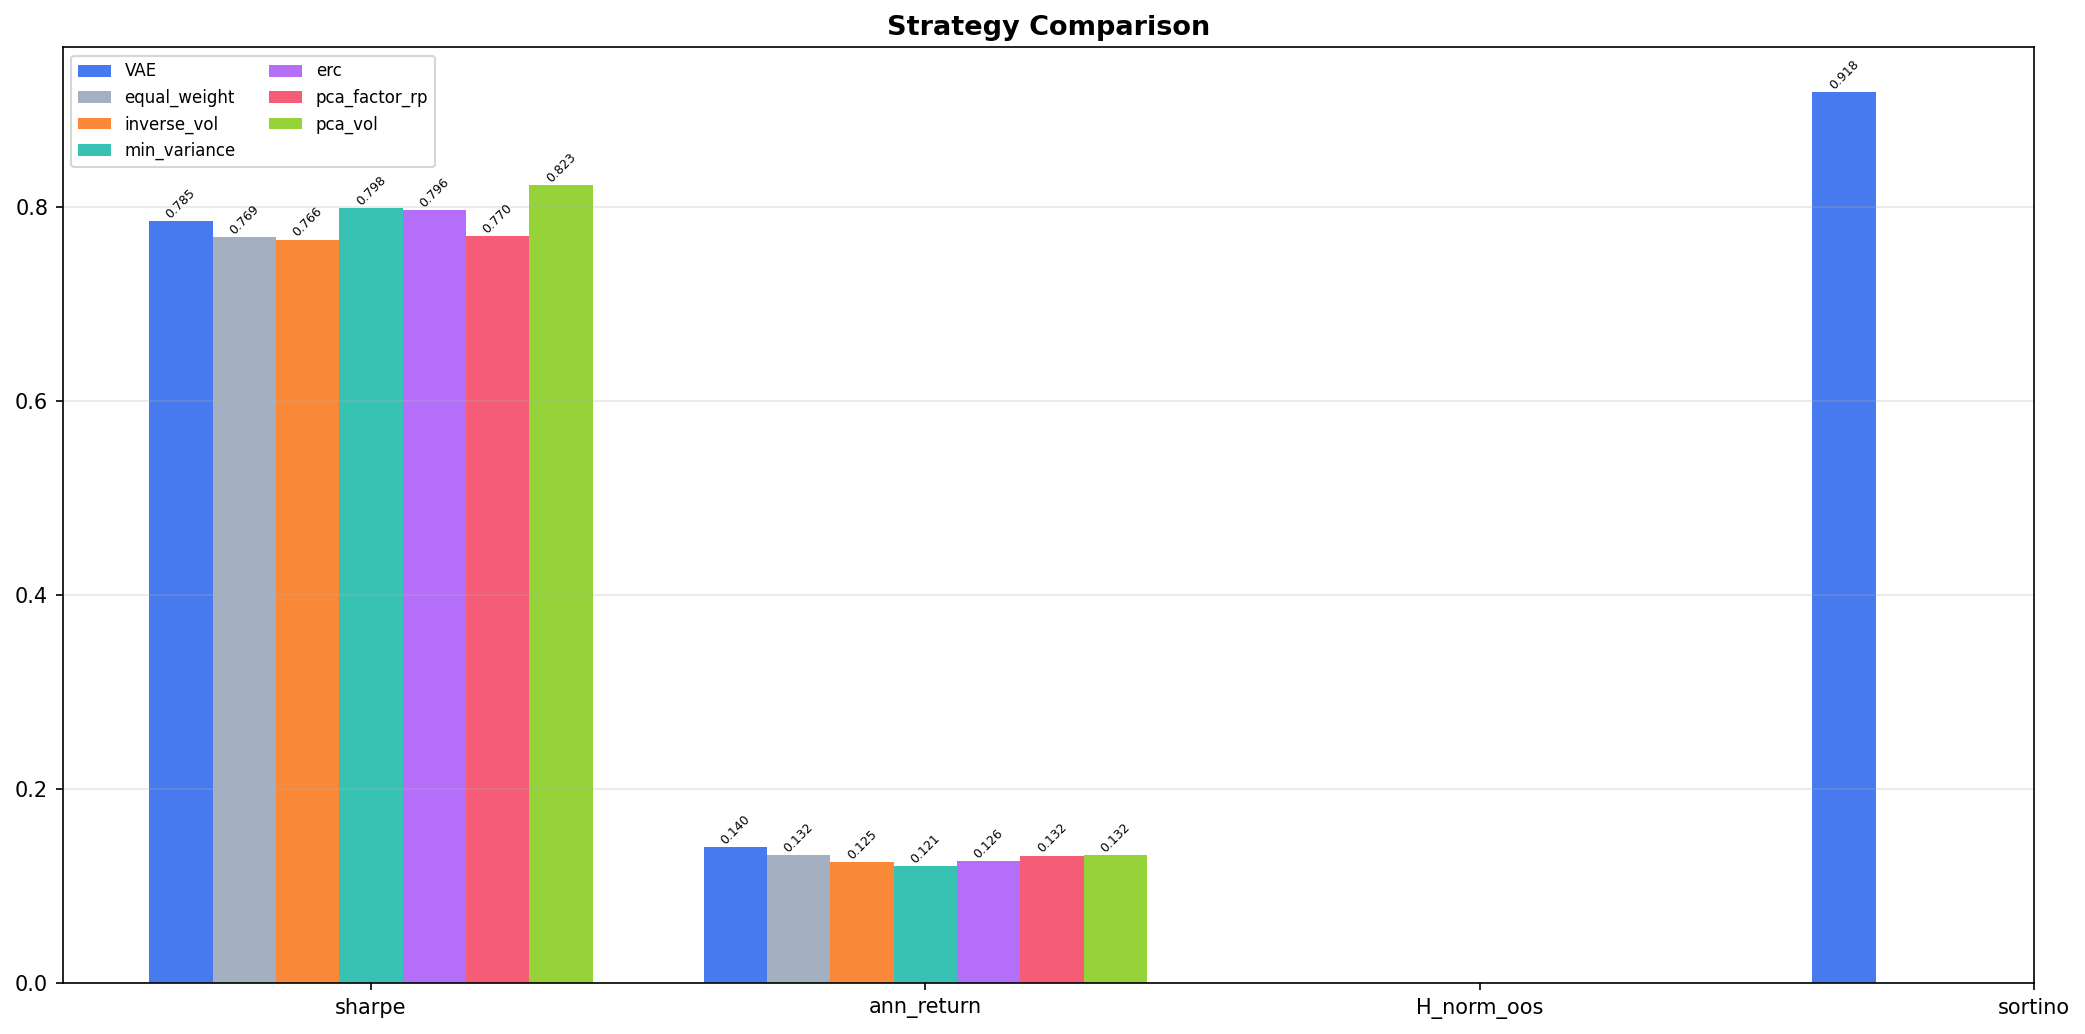

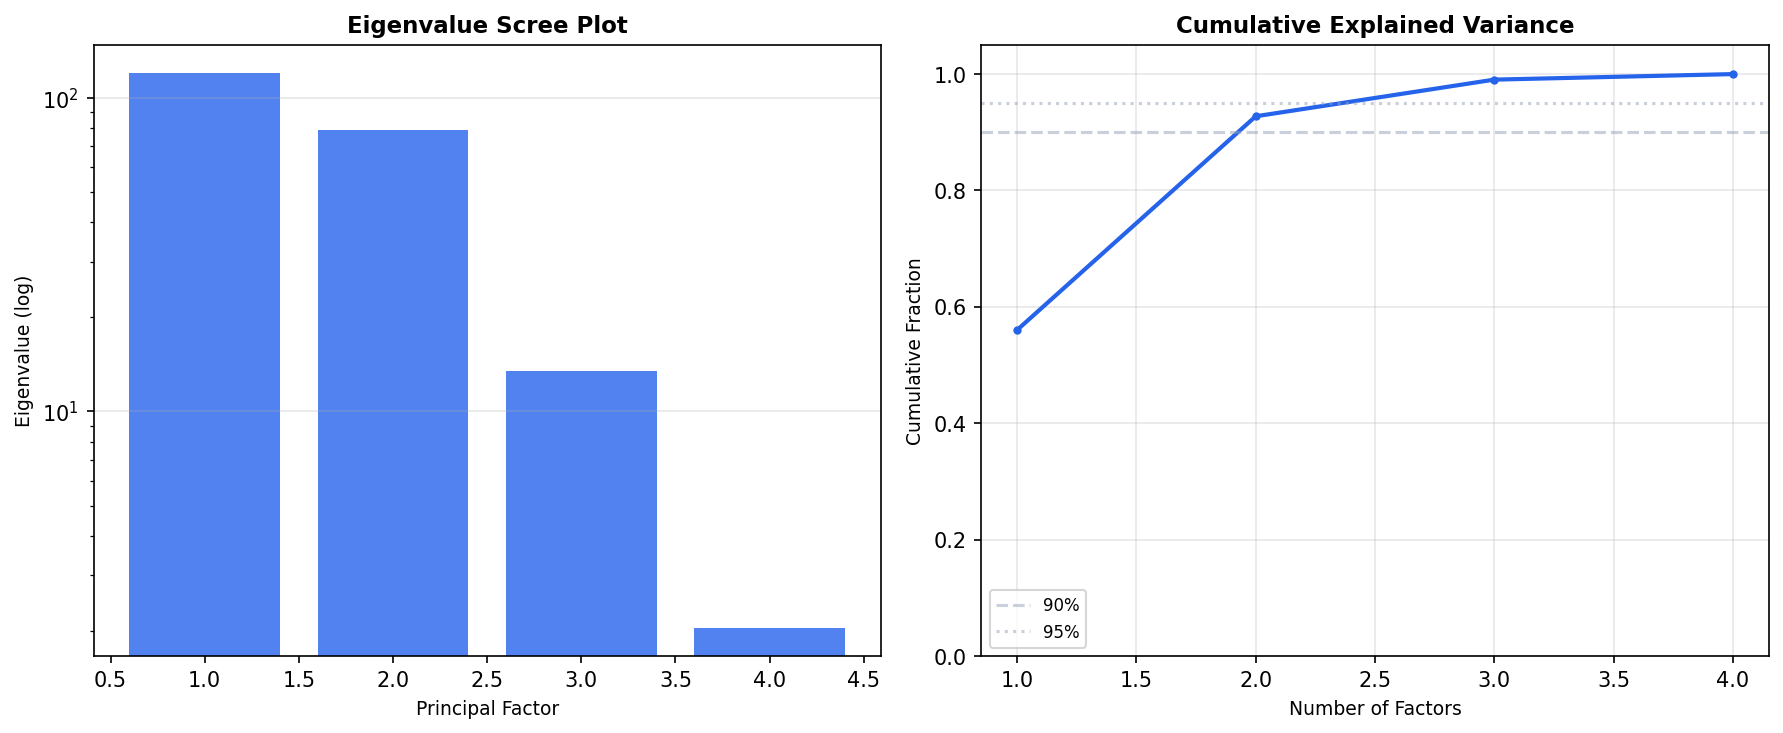

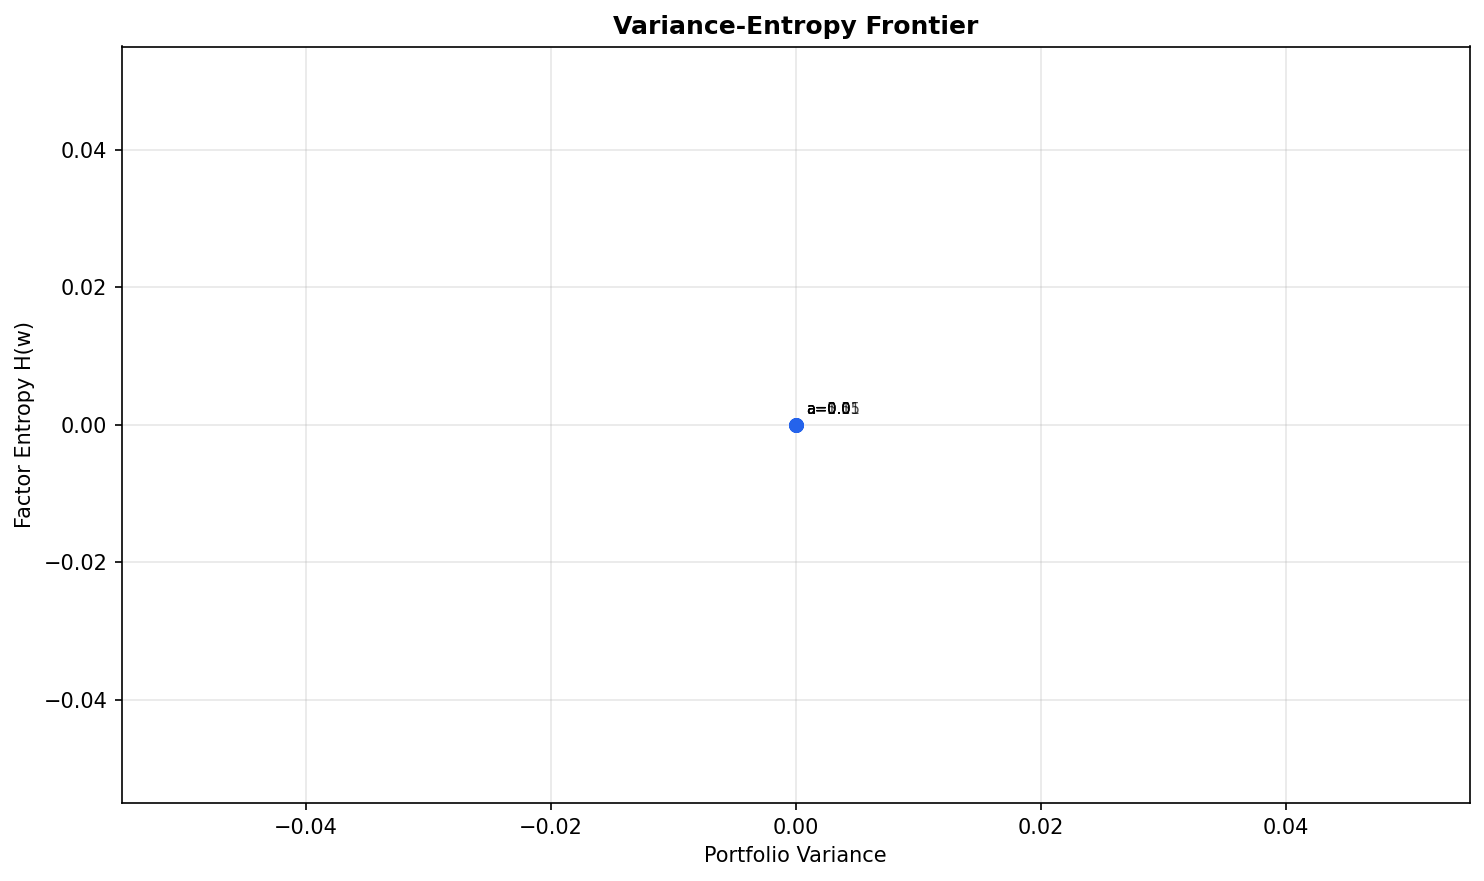

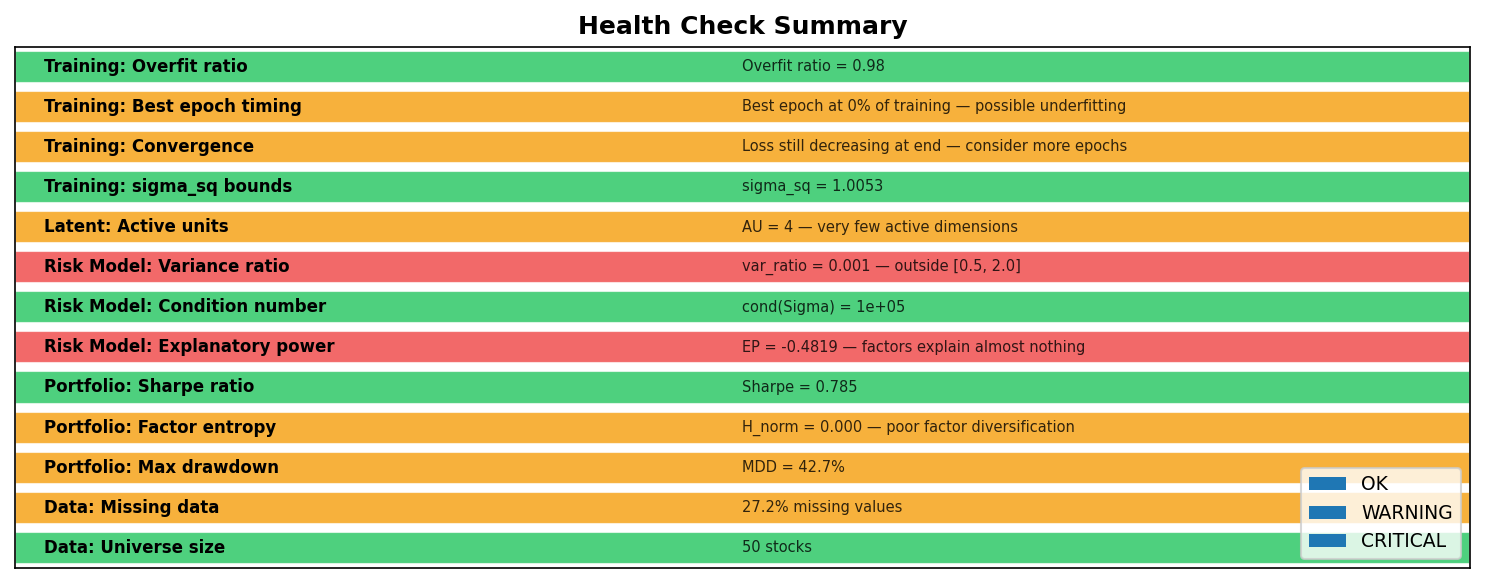

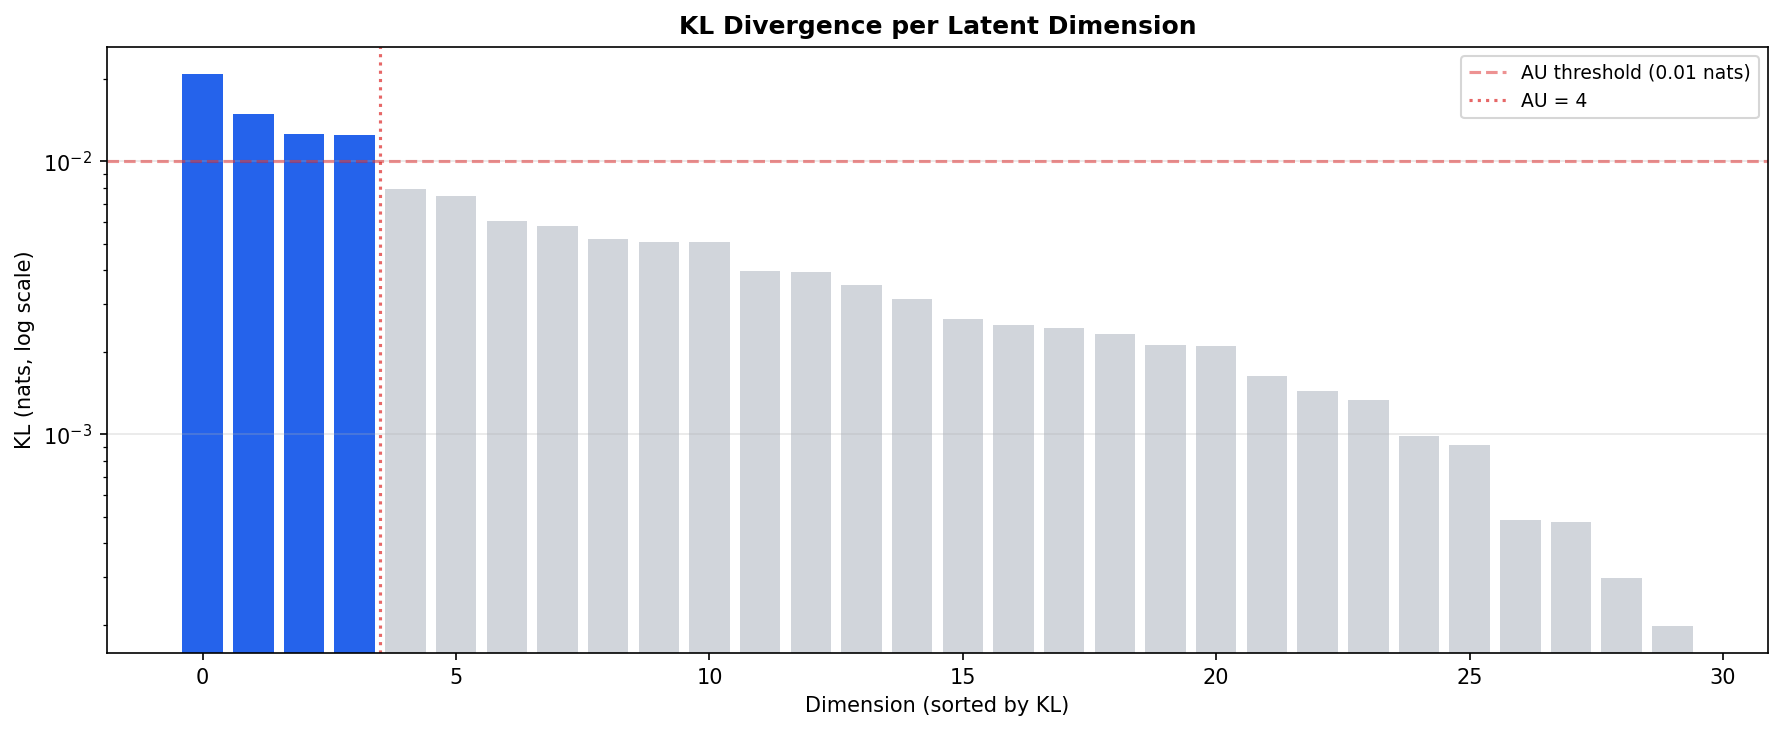

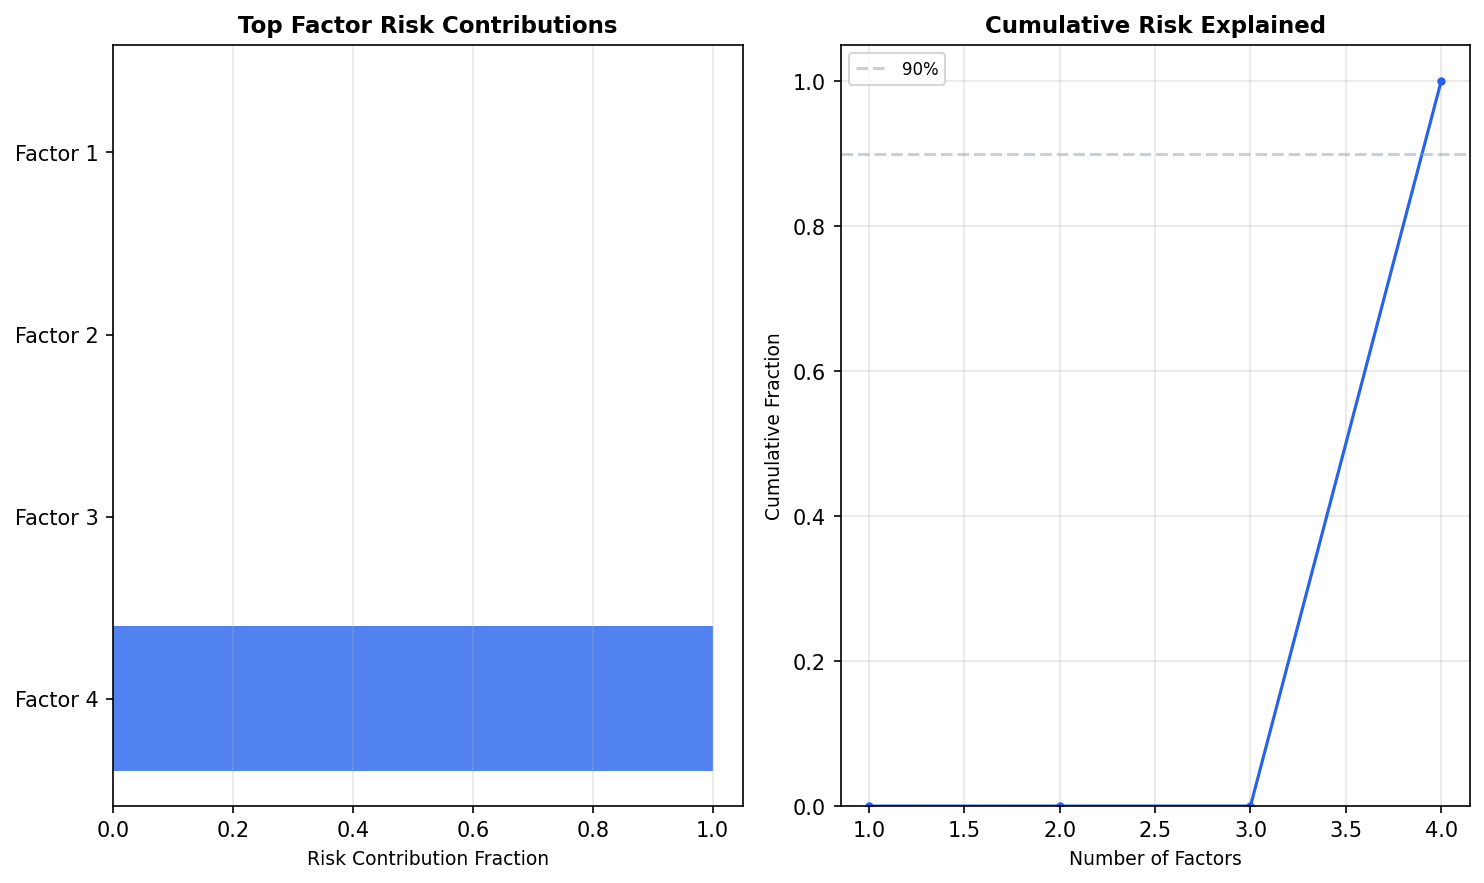

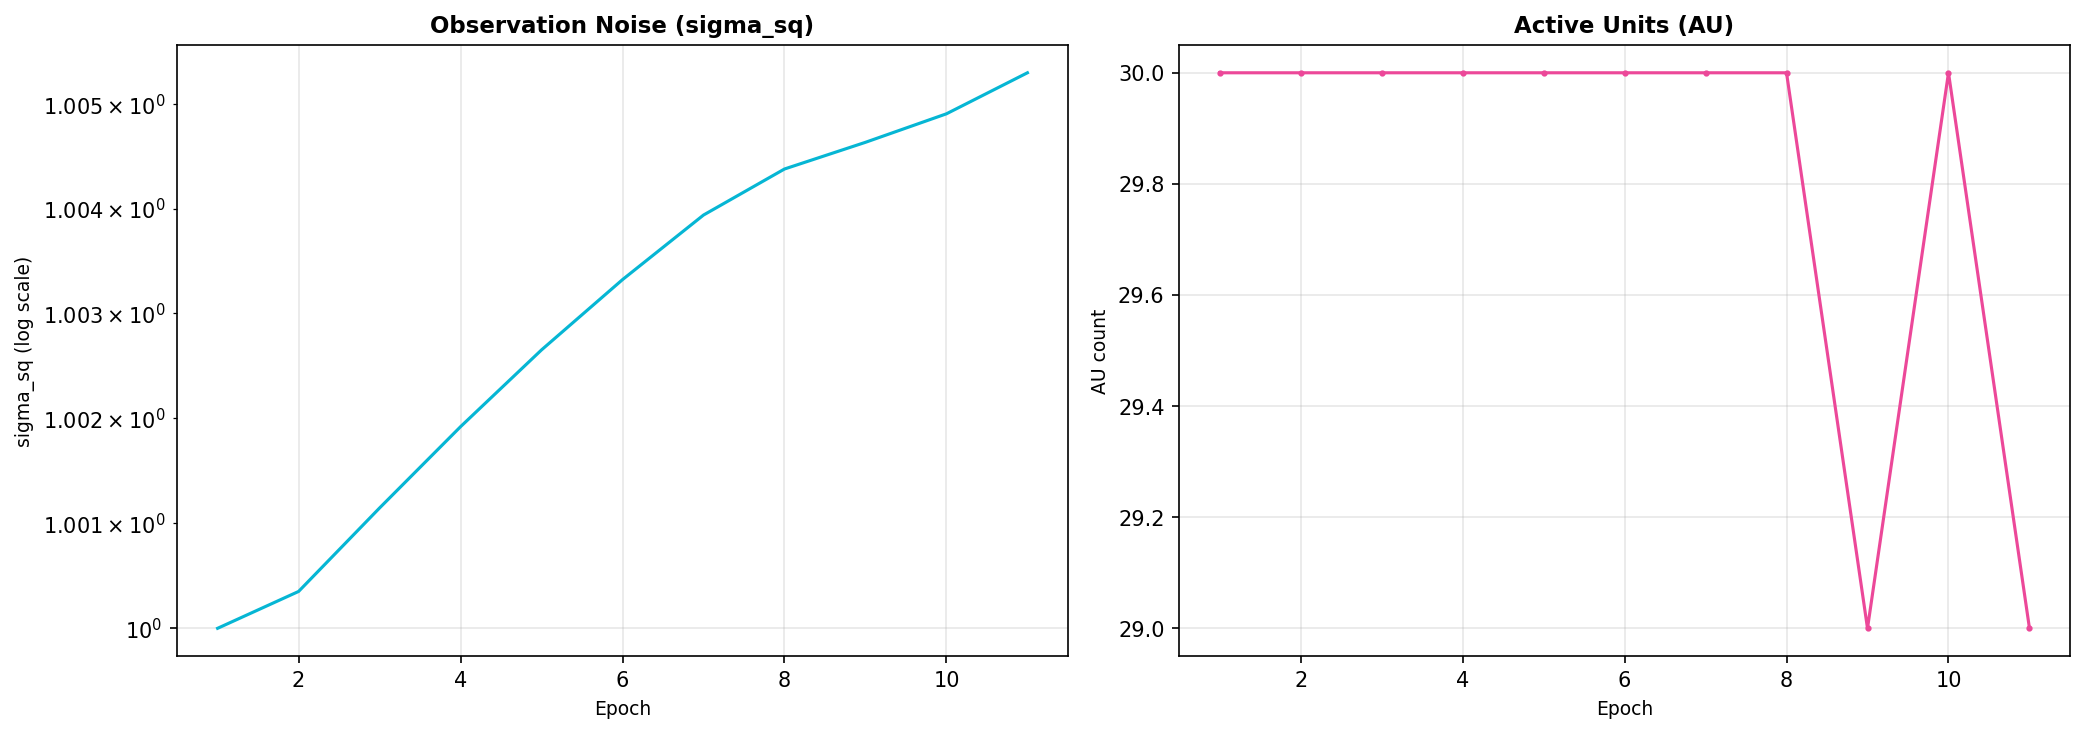

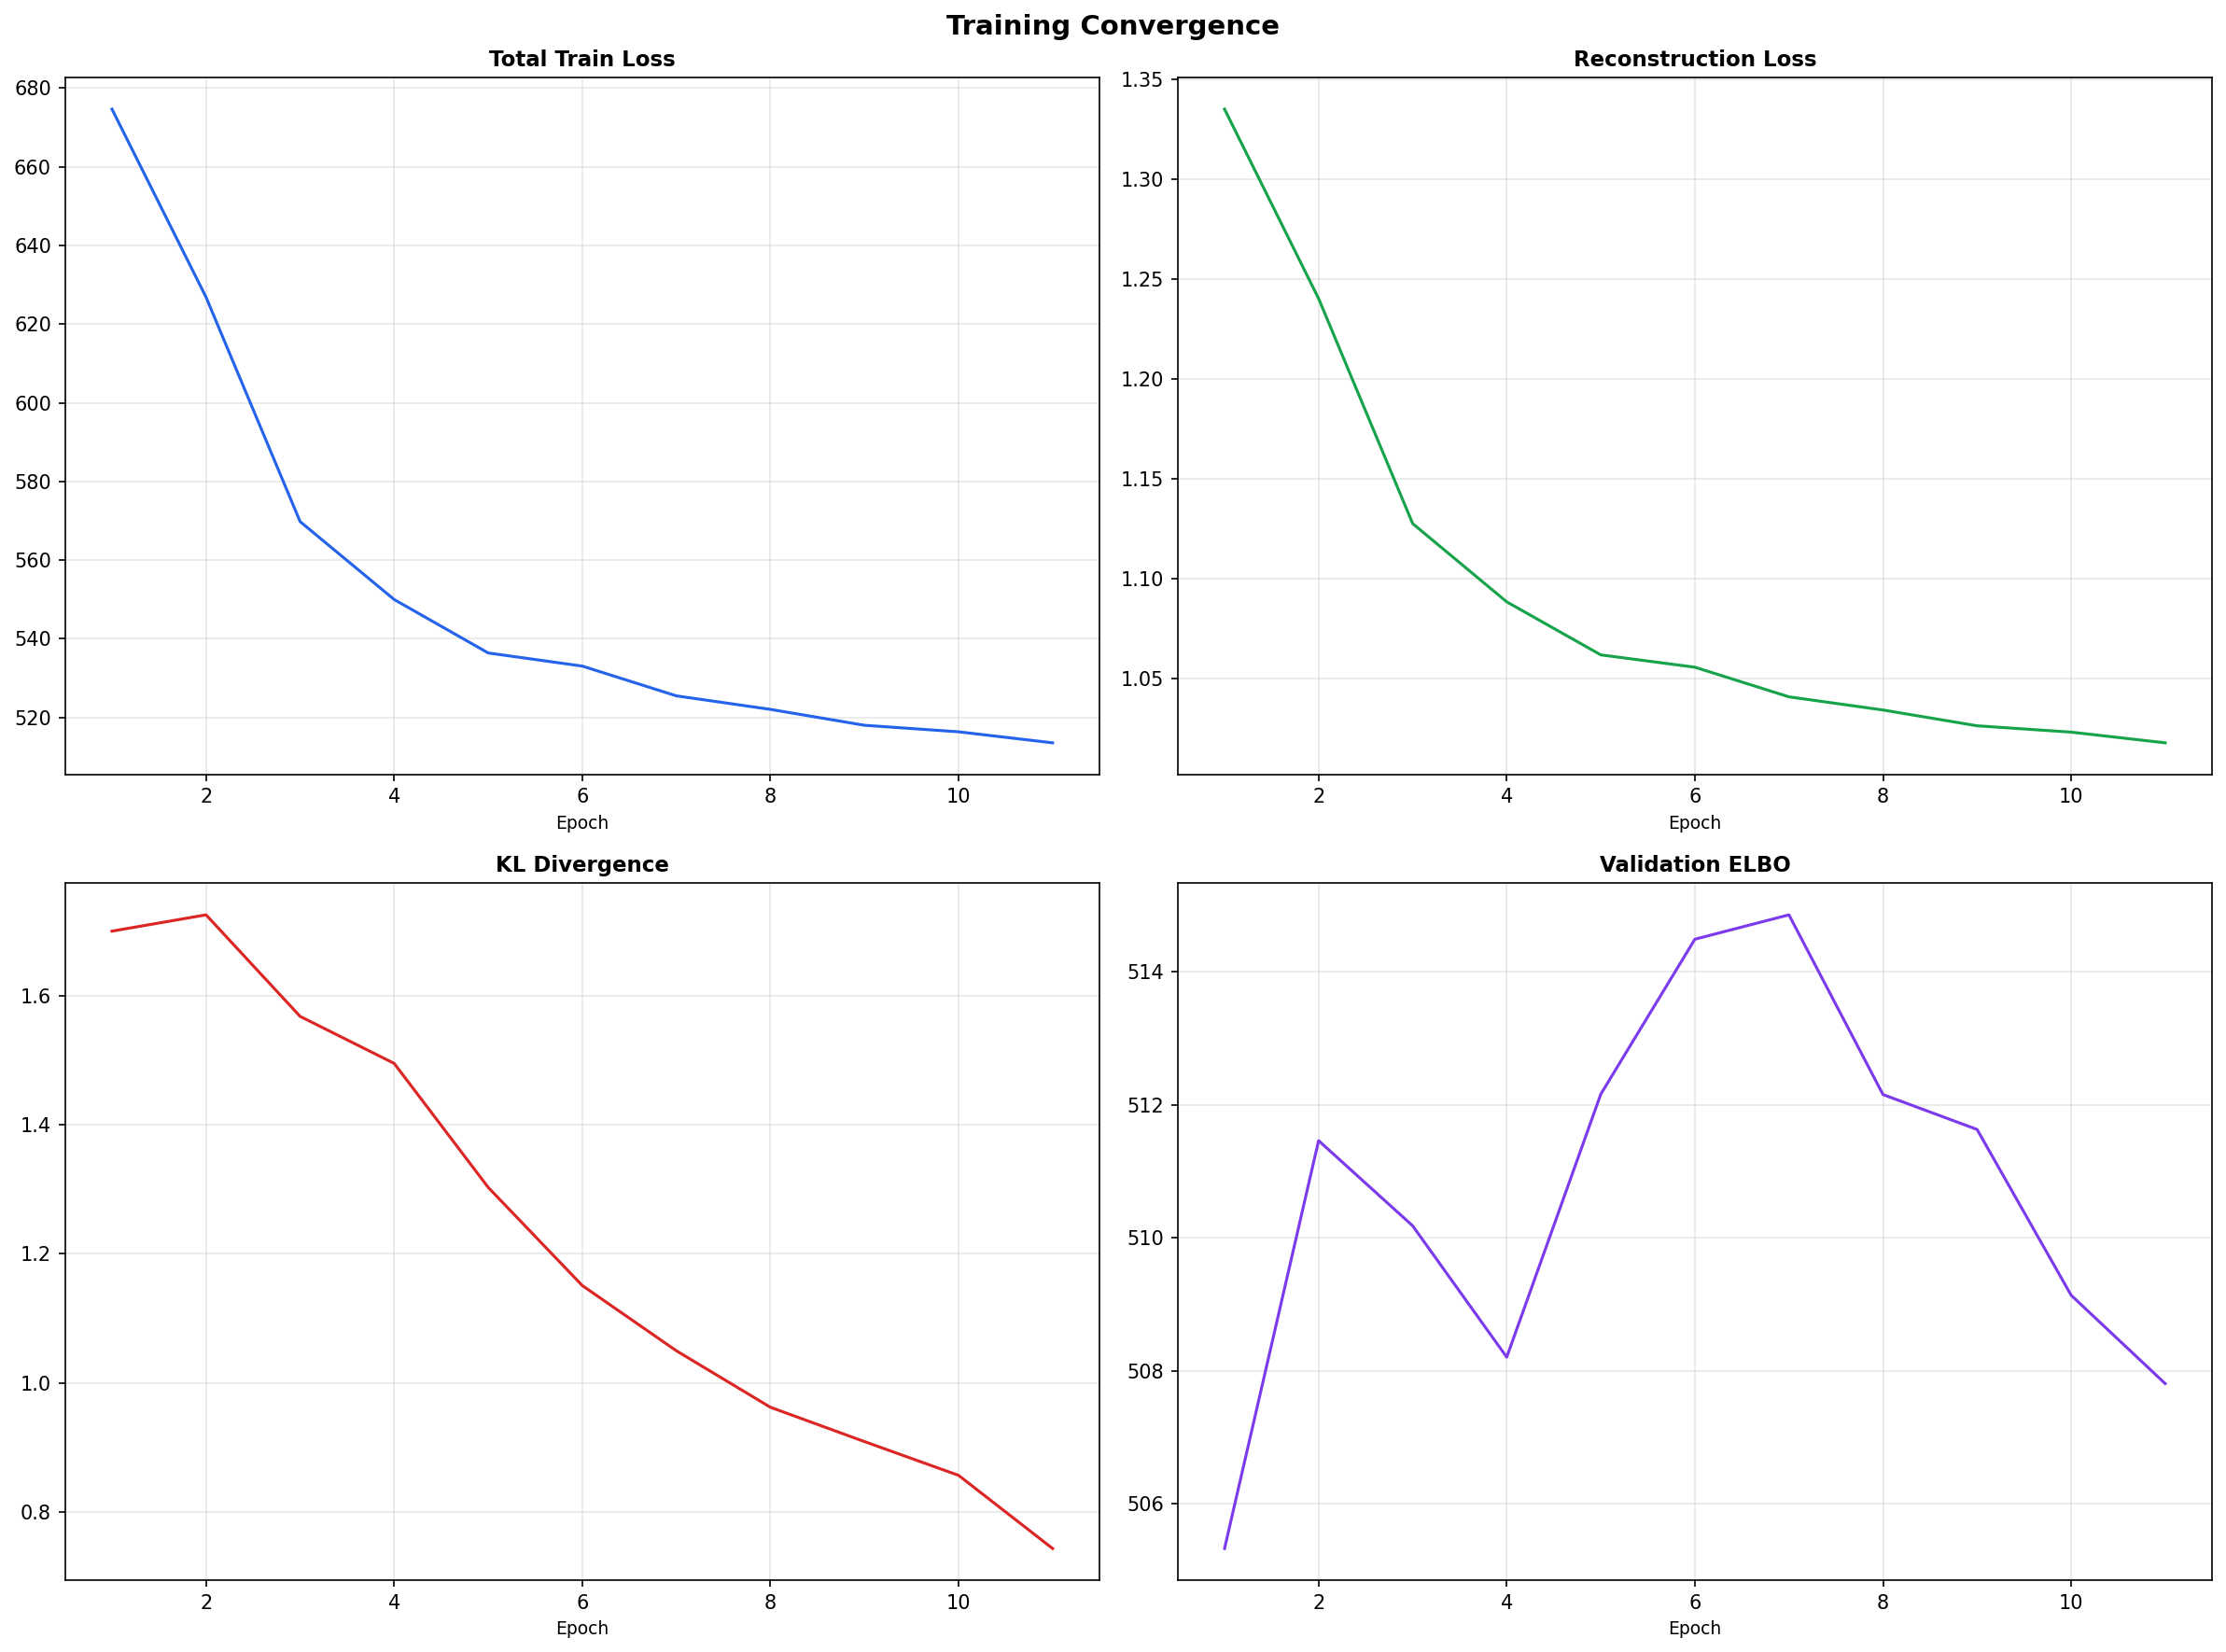

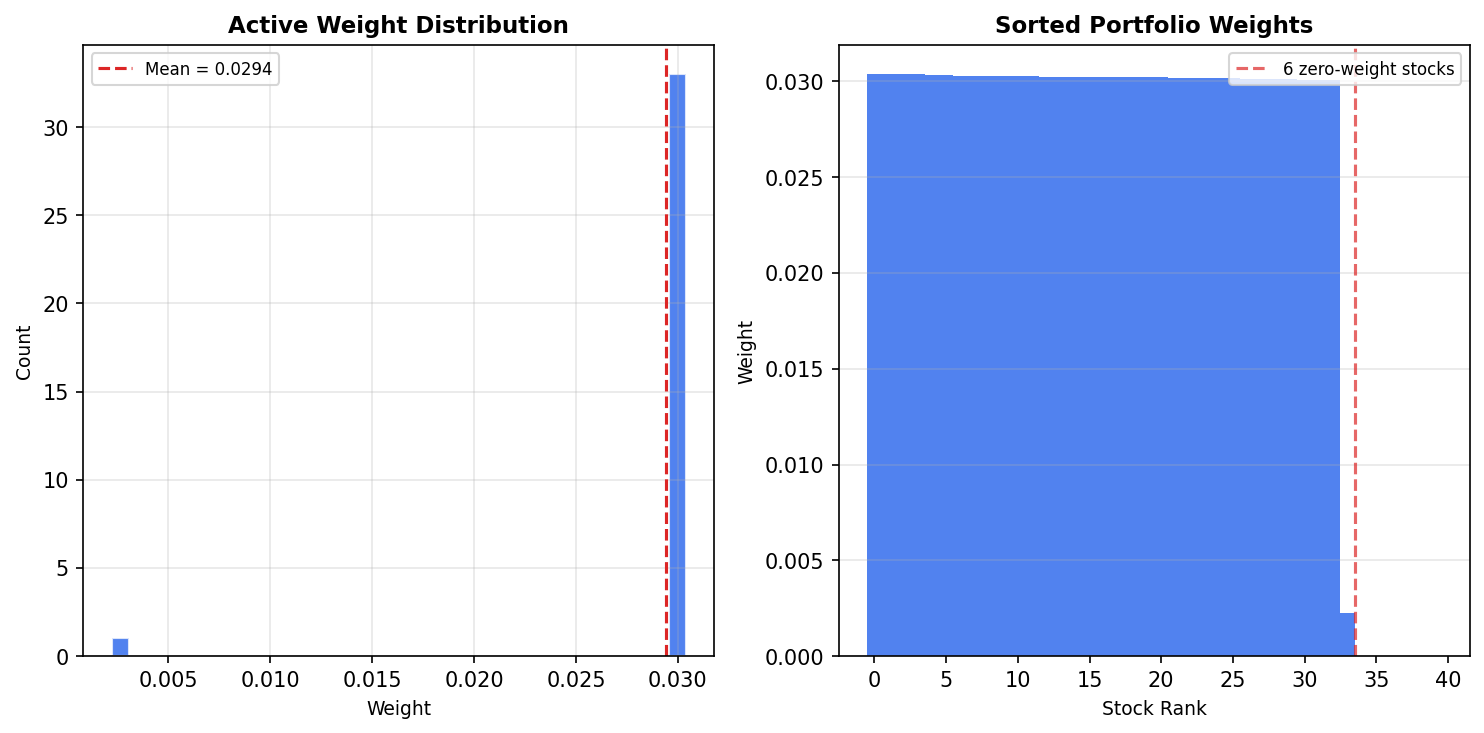

In [42]:
# ============================================================
# 9b. DISPLAY DIAGNOSTIC PLOTS (from saved PNGs)
# ============================================================
from IPython.display import display, Image as IPImage
from pathlib import Path

_plots_dir = Path(DIAG_OUTPUT_DIR) / "plots"

if _plots_dir.exists():
    _pngs = sorted(_plots_dir.glob("*.png"))
    if _pngs:
        print(f"Displaying {len(_pngs)} diagnostic plots from {_plots_dir}/\n")
        for _p in _pngs:
            display(IPImage(filename=str(_p), width=900))
    else:
        print(f"No PNG files found in {_plots_dir}/")
else:
    print(f"Plots directory not found: {_plots_dir}/  — run cell 9a first.")

In [43]:
# ============================================================
# 9c. DISPLAY MARKDOWN REPORT
# ============================================================
from IPython.display import display, Markdown
from pathlib import Path

_report_path = Path(DIAG_OUTPUT_DIR) / "diagnostic_report.md"

if _report_path.exists():
    _md_text = _report_path.read_text(encoding="utf-8")
    print(f"Report loaded from {_report_path} ({len(_md_text)} chars)\n")
    display(Markdown(_md_text))
else:
    print(f"Report not found: {_report_path}  — run cell 9a first.")

Report loaded from results/diagnostic/diagnostic_report.md (7480 chars)



# VAE Latent Risk Factor — Diagnostic Report

---

## Executive Summary

**Overall Status: ISSUES DETECTED** — 2 critical, 6 warnings, 5 OK

### Health Checks

| Status | Category | Check | Details |
|--------|----------|-------|---------|
| [OK] | Training | Overfit ratio | Overfit ratio = 0.98 |
| [WARN] | Training | Best epoch timing | Best epoch at 0% of training — possible underfitting |
| [WARN] | Training | Convergence | Loss still decreasing at end — consider more epochs |
| [OK] | Training | sigma_sq bounds | sigma_sq = 1.0053 |
| [WARN] | Latent | Active units | AU = 4 — very few active dimensions |
| [CRIT] | Risk Model | Variance ratio | var_ratio = 0.001 — outside [0.5, 2.0] |
| [OK] | Risk Model | Condition number | cond(Sigma) = 1e+05 |
| [CRIT] | Risk Model | Explanatory power | EP = -0.4819 — factors explain almost nothing |
| [OK] | Portfolio | Sharpe ratio | Sharpe = 0.785 |
| [WARN] | Portfolio | Factor entropy | H_norm = 0.000 — poor factor diversification |
| [WARN] | Portfolio | Max drawdown | MDD = 42.7% |
| [WARN] | Data | Missing data | 27.2% missing values |
| [OK] | Data | Universe size | 50 stocks |

## 1. Data Quality

- **Universe size**: 50 stocks
- **Date range**: 1995-01-03 to 2026-02-06
- **Trading days**: 7827
- **Years of data**: 31.1
- **Missing data**: 27.24%
- **Stocks > 20% missing**: 22

## 2. Training Convergence

- **Epochs**: 11
- **Best epoch**: 0 (0% of total)
- **Best val ELBO**: 505.3254
- **Overfit flag**: False
- **Overfit ratio**: 0.9839
- **Still decreasing at end**: True
- **LR reductions**: 1

### Loss Decomposition (best epoch)

| Component | Value |
|-----------|-------|
| Total loss | 674.6097 |
| Reconstruction | 1.3349 |
| KL divergence | 1.7006 |

### Observation Noise (sigma_sq)

- **Initial**: 1.0000
- **Final**: 1.0053
- **Hit lower bound**: False
- **Hit upper bound**: False

### Active Units Evolution

- **Initial**: 30
- **Final**: 29
- **Peak during training**: 30

## 3. Latent Space Analysis

- **K (latent capacity)**: 30
- **AU (active units)**: 4
- **Utilization ratio**: 13.3%
- **Effective latent dims**: 19.5
- **KL total**: 0.1402
- **KL concentration (active dims)**: 43.5%

### Exposure Matrix B

- **Shape**: [40, 30]
- **Sparsity**: 0.0%
- **Max absolute entry**: 0.1993
- **Mean dim norm**: 0.3747
- **Mean stock norm**: 0.4288

## 4. Risk Model Quality

- **Variance targeting scale**: 0.0100
- **Variance ratio (OOS)**: 5.75e-04 (target: [0.5, 2.0])
- **Rank correlation (OOS)**: 0.6253
- **Explanatory power**: -0.4819
- **Condition number**: 9.70e+04

### Eigenvalue Spectrum

- **Number of eigenvalues**: 4
- **Top eigenvalue**: 120.0016
- **Top 3 explained**: 99.0%
- **Top 10 explained**: 100.0%
- **Ratio #1/#2**: 1.53

## 5. Portfolio Optimization

- **Alpha (risk aversion)**: 5.0000
- **Active positions**: 34 / 40
- **Effective N**: 33.1
- **HHI**: 0.0302
- **Gini coefficient**: 0.0288
- **Max weight**: 0.0304
- **Min active weight**: 2.24e-03

### Factor Risk Decomposition

- **Top 1 factor contribution**: 0.0%
- **Top 3 factor contribution**: 0.0%
- **Risk entropy (H)**: 2.75e-04
- **Max possible entropy**: 1.3863

## 6. Out-of-Sample Performance

### VAE Portfolio

- **Annualized return**: 14.03%
- **Annualized volatility**: 17.88%
- **Sharpe ratio**: 0.785
- **Sortino ratio**: 0.918
- **Calmar ratio**: 0.329
- **Max drawdown**: 42.66%
- **Normalized entropy (H_norm)**: 2.03e-04

### VAE vs Benchmarks

| Metric | VAE | Equal Weight | Inverse Vol | Min Variance | Erc | Pca Factor Rp | Pca Vol |
|--------|-----|------|------|------|------|------|------|
| sharpe | 0.7847 | 0.7687 | 0.7661 | 0.7984 | 0.7962 | 0.7700 | 0.8226 |
| ann_return | 0.1403 | 0.1319 | 0.1253 | 0.1205 | 0.1264 | 0.1317 | 0.1325 |
| ann_vol_oos | 0.1788 | 0.1715 | 0.1636 | 0.1509 | 0.1587 | 0.1711 | 0.1610 |
| max_drawdown_oos | 0.4266 | 0.3965 | 0.3864 | 0.3418 | 0.3653 | 0.3948 | 0.3464 |
| H_norm_oos | 2.03e-04 | nan | nan | nan | nan | nan | nan |
| eff_n_positions | 33.1424 | 31.0000 | 28.9382 | 21.4780 | 28.3510 | 30.9940 | 20.4910 |

### Win/Loss Summary

| Benchmark | VAE Wins | VAE Losses |
|-----------|----------|------------|
| equal_weight | 3 | 3 |
| inverse_vol | 4 | 2 |
| min_variance | 2 | 4 |
| erc | 2 | 4 |
| pca_factor_rp | 3 | 3 |
| pca_vol | 2 | 4 |

**Total: 16 wins, 20 losses**

## 7. Diagnosis & Recommendations

- **Increase max_epochs**: loss was still decreasing at the end of training. The model may benefit from longer training.
- **Low AU (4/30)**: most latent dimensions are unused. Consider reducing K, increasing training data, or checking if the KL term is dominating (posterior collapse).
- **Covariance overestimation** (var_ratio = 0.001): the model predicts much more risk than observed. Check variance targeting scale and Ledoit-Wolf shrinkage.
- **Very low explanatory power** (EP = -0.4819): latent factors explain almost none of the return variance. The VAE-discovered factors may not correspond to true risk drivers.

## Appendix: Configuration

```json
{
  "data": {
    "n_stocks": 50,
    "window_length": 504,
    "n_features": 2,
    "vol_window": 252,
    "vix_lookback_percentile": 80.0,
    "min_valid_fraction": 0.8,
    "data_source": "synthetic",
    "data_dir": "data/",
    "training_stride": 63
  },
  "vae": {
    "K": 30,
    "sigma_sq_init": 1.0,
    "sigma_sq_min": 0.0001,
    "sigma_sq_max": 10.0,
    "window_length": 504,
    "n_features": 2,
    "r_max": 5.0,
    "dropout": 0.1
  },
  "loss": {
    "mode": "P",
    "gamma": 3.0,
    "lambda_co_max": 0.5,
    "beta_fixed": 1.0,
    "warmup_fraction": 0.2,
    "max_pairs": 2048,
    "delta_sync": 21
  },
  "training": {
    "max_epochs": 15,
    "batch_size": 256,
    "learning_rate": 0.0001,
    "weight_decay": 1e-05,
    "adam_betas": [
      0.9,
      0.999
    ],
    "adam_eps": 1e-08,
    "patience": 10,
    "lr_patience": 5,
    "lr_factor": 0.5,
    "n_strata": 15,
    "curriculum_phase1_frac": 0.3,
    "curriculum_phase2_frac": 0.3,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": false,
    "compile_model": false
  },
  "inference": {
    "batch_size": 512,
    "au_threshold": 0.01,
    "r_min": 2,
    "aggregation_method": "mean"
  },
  "risk_model": {
    "winsorize_lo": 5.0,
    "winsorize_hi": 95.0,
    "d_eps_floor": 1e-06,
    "conditioning_threshold": 1000000.0,
    "ridge_scale": 1e-06
  },
  "portfolio": {
    "lambda_risk": 1.0,
    "w_max": 0.05,
    "w_min": 0.001,
    "w_bar": 0.03,
    "phi": 25.0,
    "kappa_1": 0.1,
    "kappa_2": 7.5,
    "delta_bar": 0.01,
    "tau_max": 0.3,
    "n_starts": 2,
    "sca_max_iter": 100,
    "sca_tol": 1e-08,
    "armijo_c": 0.0001,
    "armijo_rho": 0.5,
    "armijo_max_iter": 20,
    "max_cardinality_elim": 100,
    "entropy_eps": 1e-30,
    "cardinality_method": "auto",
    "alpha_grid": [
      0.0,
      0.01,
      0.05,
      0.1,
      0.5,
      1.0,
      5.0
    ]
  },
  "walk_forward": {
    "total_years": 30,
    "min_training_years": 10,
    "oos_months": 6,
    "embargo_days": 21,
    "holdout_years": 3,
    "val_years": 2,
    "score_lambda_pen": 5.0,
    "score_lambda_est": 2.0,
    "score_mdd_threshold": 0.2
  },
  "seed": 42,
  "_diagnostic": {
    "profile": "quick",
    "data_source": "tiingo",
    "n_stocks_actual": 50,
    "n_dates_actual": 7827,
    "date_range": "1995-01-03 to 2026-02-06",
    "pipeline_time_seconds": 105.59902604203671,
    "holdout_fraction": 0.3,
    "loss_mode": "P"
  }
}
```
